<a href="https://colab.research.google.com/github/Lookieman/home_projects/blob/main/ThinkOnwardsComp/Phase1_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This phase trains a U-Net model to get a baseline MAPE.

The model uses the flag USE_ADAPTIVE_MODEL to switch between:

a. Mode that resizes the training data ((10001, 31) → (300, 1259) via interpolation), stack as a 5-channel i/p as baseline.

b. Model that uses "adaptive-inside" model when Flag is True

Objective is to test code and also compare MAPE to be used as baseline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configuration
USE_ADAPTIVE_MODEL = True  # Set to True for adaptive model, False for resize model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
TRAIN_VAL_SPLIT = 0.8

print(f"Using device: {DEVICE}")
print(f"Model type: {'Adaptive' if USE_ADAPTIVE_MODEL else 'Resize'}")

Using device: cuda
Model type: Adaptive


In [ ]:
class SeismicDataset(Dataset):
    def __init__(self, data_dir, sample_indices, use_adaptive=False):
        self.data_dir = data_dir
        self.sample_indices = sample_indices
        self.use_adaptive = use_adaptive
        self.receiver_files = [
            'receiver_data_src_1.npy',
            'receiver_data_src_75.npy',
            'receiver_data_src_150.npy',
            'receiver_data_src_225.npy',
            'receiver_data_src_300.npy'
        ]

    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        sample_idx = self.sample_indices[idx]
        sample_dir = os.path.join(self.data_dir, f'TrainingData_{sample_idx}')

        # Load receiver data (5 files)
        receiver_data = []
        for file_name in self.receiver_files:
            file_path = os.path.join(sample_dir, file_name)
            data = np.load(file_path).astype(np.float32)  # (10001, 31)
            receiver_data.append(data)

        # Load target velocity model
        target_path = os.path.join(sample_dir, 'vp_model.npy')
        target = np.load(target_path).astype(np.float32)  # (300, 1259)

        if self.use_adaptive:
            # Process for adaptive model
            processed_inputs = []
            for data in receiver_data:
                # 1D conv + maxpool simulation using numpy
                # Downsample from 10001 to ~313 (factor of ~32)
                downsampled = data[::32, :]  # (313, 31)

                # Zero pad from 31 to 32 channels
                if downsampled.shape[1] == 31:
                    padded = np.pad(downsampled, ((0, 0), (0, 1)), mode='constant')  # (313, 32)
                else:
                    padded = downsampled

                # Reshape to make it more compact 2D
                # We'll treat this as (313, 32) for now and let the model handle it
                processed_inputs.append(padded.T)  # (32, 313) for easier processing

            # Stack all 5 processed inputs
            input_tensor = np.stack(processed_inputs, axis=0)  # (5, 32, 313)
        else:
            # Process for resize model
            processed_inputs = []
            for data in receiver_data:
                # Resize (10001, 31) to (300, 1259)
                resized = ndimage.zoom(data, (300/10001, 1259/31), order=1)
                processed_inputs.append(resized)

            # Stack all 5 processed inputs
            input_tensor = np.stack(processed_inputs, axis=0)  # (5, 300, 1259)

        return torch.from_numpy(input_tensor), torch.from_numpy(target)


In [ ]:
from math import e
# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.conv1(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.conv2(x).view(batch_size, -1, width * height)
        value = self.conv3(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)
        attention = self.softmax(attention)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        return self.gamma * out + x

# Double Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, use_adaptive=False):
        super(UNet, self).__init__()
        self.use_adaptive = use_adaptive

        if use_adaptive:
            # First process the irregular input
            self.input_processor = nn.Sequential(
                nn.Conv2d(5, 16, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
            # Input will be (5, 32, 313), output will be (32, 32, 313)
            in_channels = 32

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck with attention
        self.bottleneck = DoubleConv(512, 1024)
        self.attention = AttentionBlock(1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Final output
        self.final_conv = nn.Conv2d(64, out_channels, 1)

        if use_adaptive:
            # Final upsampling to reach (300, 1259)
            self.final_upsample = nn.Sequential(
                nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        if self.use_adaptive:
            # Process irregular input first
            x = self.input_processor(x)  # (batch, 32, 32, 313)

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))
        b = self.attention(b)

        # Decoder with skip connections
        d4 = self.up4(b)
        d4 = match_tensor_size(d4, e4)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = match_tensor_size(d3, e3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = match_tensor_size(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = match_tensor_size(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final output
        output = self.final_conv(d1)

        if self.use_adaptive:
            # Upsample to final target size (300, 1259)
            output = F.interpolate(output, size=(300, 1259), mode='bilinear', align_corners=False)

        return output

In [ ]:
# Helper function to match tensor sizes for skip connections
def match_tensor_size(tensor1, tensor2):
    """Match the spatial dimensions of tensor1 to tensor2 by cropping or padding."""
    _, _, h1, w1 = tensor1.shape
    _, _, h2, w2 = tensor2.shape

    # Calculate differences
    dh = h2 - h1
    dw = w2 - w1

    if dh > 0 or dw > 0:
        # Pad tensor1 if it's smaller
        pad_h = max(0, dh)
        pad_w = max(0, dw)
        tensor1 = F.pad(tensor1, (0, pad_w, 0, pad_h))
    elif dh < 0 or dw < 0:
        # Crop tensor1 if it's larger
        tensor1 = tensor1[:, :, :h2, :w2]

    return tensor1

# MAPE Loss Function
def mape_loss(predictions, targets, epsilon=1e-8):
    targets_safe = torch.clamp(torch.abs(targets), min=epsilon)
    return torch.mean(torch.abs((targets - predictions) / targets_safe)) * 100

# Training Function
def train_model(model, train_loader, val_loader, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

    model_path = Path('/content/drive/MyDrive/ThinkOnward/Models/')
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_idx, (inputs, targets) in enumerate(train_progress):
          try:
            # *** DEBUG: Print shapes and memory usage for first few batches ***
            if batch_idx < 3:
                print(f"*** DEBUG Batch {batch_idx}: Input shape: {inputs.shape}, Target shape: {targets.shape} ***")
                if torch.cuda.is_available():
                    print(f"*** DEBUG: GPU memory before forward: {torch.cuda.memory_allocated()/1e9:.2f}GB ***")

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            targets = targets.unsqueeze(1)  # Add channel dimension

            if batch_idx < 3:
                print(f"*** DEBUG: Starting forward pass for batch {batch_idx} ***")

            optimizer.zero_grad()
            outputs = model(inputs)

            if batch_idx < 3:
                print(f"*** DEBUG: Forward pass complete, output shape: {outputs.shape} ***")
                print(f"*** DEBUG: Starting loss calculation ***")

            loss = mape_loss(outputs, targets)

            if batch_idx < 3:
                print(f"*** DEBUG: Loss calculated: {loss.item():.4f}, starting backward ***")

            loss.backward()

            if batch_idx < 3:
                print(f"*** DEBUG: Backward complete, running optimizer step ***")

            optimizer.step()

            if batch_idx < 3:
                print(f"*** DEBUG: Batch {batch_idx} complete ***")
                if torch.cuda.is_available():
                    print(f"*** DEBUG: GPU memory after batch: {torch.cuda.memory_allocated()/1e9:.2f}GB ***")

            train_loss += loss.item()
            train_progress.set_postfix({'Loss': f'{loss.item():.4f}'})

            # *** DEBUG: Force flush every 10 batches to see progress ***
            if batch_idx % 10 == 0:
                print(f"*** DEBUG: Completed batch {batch_idx}/{len(train_loader)} ***")

          except Exception as e:
            print(f"*** ERROR in batch {batch_idx}: {str(e)} ***")
            print(f"*** Input shape: {inputs.shape if 'inputs' in locals() else 'Not loaded'} ***")
            print(f"*** Target shape: {targets.shape if 'targets' in locals() else 'Not loaded'} ***")
            raise e

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"*** DEBUG: Training epoch {epoch+1} complete, starting validation ***")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

            for batch_idx, (inputs, targets) in enumerate(val_progress):
              try:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                targets = targets.unsqueeze(1)

                outputs = model(inputs)
                loss = mape_loss(outputs, targets)
                val_loss += loss.item()
                val_progress.set_postfix({'Loss': f'{loss.item():.4f}'})
              except Exception as e:
                print(f"*** ERROR in validation batch {batch_idx}: {str(e)} ***")
                raise e


        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train MAPE: {avg_train_loss:.4f}%')
        print(f'  Val MAPE: {avg_val_loss:.4f}%')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_name = model_path / f'best_model_{"adaptive" if USE_ADAPTIVE_MODEL else "resize"}.pth'
            torch.save(model.state_dict(), model_name)
            print(f'New best model saved: {model_name}')

    return train_losses, val_losses

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training samples: 1600
Validation samples: 400
Model parameters: 32,356,674

Testing model with one batch...
Input shape: torch.Size([16, 5, 300, 1259])
Target shape: torch.Size([16, 300, 1259])
Output shape: torch.Size([16, 1, 300, 1259])
Test MAPE: 90.6181%

Starting training...


Epoch 1/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s, Loss=44.5640]


Epoch 1/50:
  Train MAPE: 54.5560%
  Val MAPE: 44.5335%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s, Loss=35.5727]


Epoch 2/50:
  Train MAPE: 38.5587%
  Val MAPE: 35.5246%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s, Loss=28.9884]


Epoch 3/50:
  Train MAPE: 31.3107%
  Val MAPE: 28.8704%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s, Loss=19.1890]


Epoch 4/50:
  Train MAPE: 24.7800%
  Val MAPE: 19.4848%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s, Loss=21.9129]


Epoch 5/50:
  Train MAPE: 17.8843%
  Val MAPE: 21.9283%
  LR: 0.000100
--------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.42it/s, Loss=19.0960]


Epoch 6/50:
  Train MAPE: 11.4592%
  Val MAPE: 18.8585%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=11.8705]


Epoch 7/50:
  Train MAPE: 7.2607%
  Val MAPE: 12.1243%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s, Loss=14.9515]


Epoch 8/50:
  Train MAPE: 6.0940%
  Val MAPE: 14.8195%
  LR: 0.000100
--------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, Loss=21.1326]


Epoch 9/50:
  Train MAPE: 5.6200%
  Val MAPE: 20.3362%
  LR: 0.000100
--------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s, Loss=8.4488]


Epoch 10/50:
  Train MAPE: 5.2730%
  Val MAPE: 8.4052%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s, Loss=9.2490]


Epoch 11/50:
  Train MAPE: 5.0019%
  Val MAPE: 9.6158%
  LR: 0.000100
--------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=8.9041]


Epoch 12/50:
  Train MAPE: 4.9259%
  Val MAPE: 8.6394%
  LR: 0.000100
--------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, Loss=7.5614]


Epoch 13/50:
  Train MAPE: 4.8456%
  Val MAPE: 7.1540%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s, Loss=15.0475]


Epoch 14/50:
  Train MAPE: 4.6207%
  Val MAPE: 14.8098%
  LR: 0.000100
--------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s, Loss=10.8908]


Epoch 15/50:
  Train MAPE: 4.5561%
  Val MAPE: 10.7483%
  LR: 0.000100
--------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s, Loss=9.3701]


Epoch 16/50:
  Train MAPE: 4.5030%
  Val MAPE: 9.1883%
  LR: 0.000100
--------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=18.2779]


Epoch 17/50:
  Train MAPE: 4.3713%
  Val MAPE: 18.0000%
  LR: 0.000100
--------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, Loss=17.3100]


Epoch 18/50:
  Train MAPE: 4.3450%
  Val MAPE: 16.7676%
  LR: 0.000100
--------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, Loss=7.0827]


Epoch 19/50:
  Train MAPE: 4.2626%
  Val MAPE: 6.8606%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 20/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s, Loss=8.6156]


Epoch 20/50:
  Train MAPE: 4.2142%
  Val MAPE: 8.1597%
  LR: 0.000100
--------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=19.3362]


Epoch 21/50:
  Train MAPE: 4.1127%
  Val MAPE: 19.1194%
  LR: 0.000100
--------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s, Loss=8.0883]


Epoch 22/50:
  Train MAPE: 4.2382%
  Val MAPE: 8.0284%
  LR: 0.000100
--------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s, Loss=12.3149]


Epoch 23/50:
  Train MAPE: 4.1725%
  Val MAPE: 12.2015%
  LR: 0.000100
--------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s, Loss=7.8244]


Epoch 24/50:
  Train MAPE: 4.1073%
  Val MAPE: 7.9872%
  LR: 0.000100
--------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s, Loss=10.1924]


Epoch 25/50:
  Train MAPE: 4.1052%
  Val MAPE: 10.0029%
  LR: 0.000010
--------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s, Loss=3.9065]


Epoch 26/50:
  Train MAPE: 3.6559%
  Val MAPE: 3.8926%
  LR: 0.000010
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 27/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s, Loss=4.1063]


Epoch 27/50:
  Train MAPE: 3.5581%
  Val MAPE: 4.0239%
  LR: 0.000010
--------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, Loss=3.7138]


Epoch 28/50:
  Train MAPE: 3.5316%
  Val MAPE: 3.7260%
  LR: 0.000010
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 29/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, Loss=4.1512]


Epoch 29/50:
  Train MAPE: 3.5315%
  Val MAPE: 4.1258%
  LR: 0.000010
--------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s, Loss=4.0258]


Epoch 30/50:
  Train MAPE: 3.5178%
  Val MAPE: 3.9552%
  LR: 0.000010
--------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=4.4790]


Epoch 31/50:
  Train MAPE: 3.5478%
  Val MAPE: 4.4872%
  LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=4.2425]


Epoch 32/50:
  Train MAPE: 3.5231%
  Val MAPE: 4.1534%
  LR: 0.000010
--------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, Loss=4.2958]


Epoch 33/50:
  Train MAPE: 3.4982%
  Val MAPE: 4.2330%
  LR: 0.000010
--------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, Loss=4.2803]


Epoch 34/50:
  Train MAPE: 3.4635%
  Val MAPE: 4.2085%
  LR: 0.000001
--------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.38it/s, Loss=3.6905]


Epoch 35/50:
  Train MAPE: 3.4558%
  Val MAPE: 3.6449%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 36/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s, Loss=3.7591]


Epoch 36/50:
  Train MAPE: 3.4679%
  Val MAPE: 3.6682%
  LR: 0.000001
--------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s, Loss=3.7016]


Epoch 37/50:
  Train MAPE: 3.4507%
  Val MAPE: 3.6403%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 38/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s, Loss=3.6820]


Epoch 38/50:
  Train MAPE: 3.4152%
  Val MAPE: 3.6295%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 39/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s, Loss=3.6992]


Epoch 39/50:
  Train MAPE: 3.4203%
  Val MAPE: 3.6324%
  LR: 0.000001
--------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=3.7073]


Epoch 40/50:
  Train MAPE: 3.3950%
  Val MAPE: 3.6420%
  LR: 0.000001
--------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s, Loss=3.7049]


Epoch 41/50:
  Train MAPE: 3.4030%
  Val MAPE: 3.6365%
  LR: 0.000001
--------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s, Loss=3.6623]


Epoch 42/50:
  Train MAPE: 3.4559%
  Val MAPE: 3.6290%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


Epoch 43/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, Loss=3.6404]


Epoch 43/50:
  Train MAPE: 3.3950%
  Val MAPE: 3.6487%
  LR: 0.000001
--------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s, Loss=3.6977]


Epoch 44/50:
  Train MAPE: 3.4228%
  Val MAPE: 3.6367%
  LR: 0.000001
--------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s, Loss=3.7291]


Epoch 45/50:
  Train MAPE: 3.4977%
  Val MAPE: 3.6527%
  LR: 0.000001
--------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s, Loss=3.6800]


Epoch 46/50:
  Train MAPE: 3.3922%
  Val MAPE: 3.6414%
  LR: 0.000001
--------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s, Loss=3.6807]


Epoch 47/50:
  Train MAPE: 3.3907%
  Val MAPE: 3.6344%
  LR: 0.000001
--------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, Loss=3.6830]


Epoch 48/50:
  Train MAPE: 3.3958%
  Val MAPE: 3.6357%
  LR: 0.000000
--------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s, Loss=3.7054]


Epoch 49/50:
  Train MAPE: 3.4081%
  Val MAPE: 3.6380%
  LR: 0.000000
--------------------------------------------------


Epoch 50/50 [Val]: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, Loss=3.6575]


Epoch 50/50:
  Train MAPE: 3.3771%
  Val MAPE: 3.6212%
  LR: 0.000000
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_resize.pth


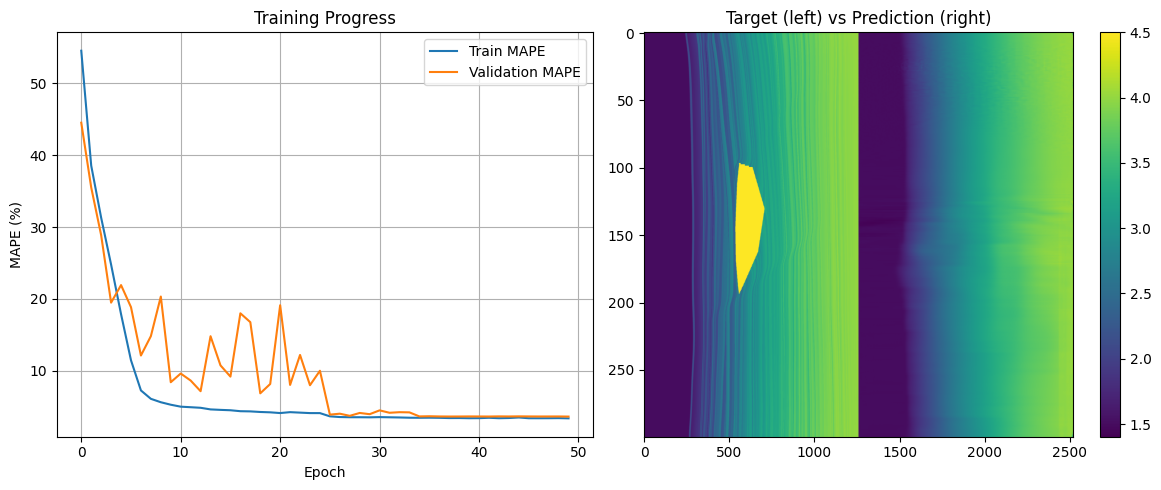


Training completed!
Best validation MAPE: 3.6212%
Model type: Resize


In [ ]:
# Main execution
if __name__ == "__main__":

    # Set data directory
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path('/content/drive/MyDrive/ThinkOnward/Data/Train')  # Adjust path as needed
    result_dir= Path('/content/drive/MyDrive/ThinkOnward/Result')

    # Create sample indices (assuming folders are named sample_0000, sample_0001, etc.)
    sample_indices = list(range(1,2001))  # Adjust based on your actual data

    # Train-validation split
    train_indices, val_indices = train_test_split(
        sample_indices,
        train_size=TRAIN_VAL_SPLIT,
        random_state=42
    )

    print(f"Training samples: {len(train_indices)}")
    print(f"Validation samples: {len(val_indices)}")

    # Create datasets
    train_dataset = SeismicDataset(data_dir, train_indices, use_adaptive=USE_ADAPTIVE_MODEL)
    val_dataset = SeismicDataset(data_dir, val_indices, use_adaptive=USE_ADAPTIVE_MODEL)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)

    # Initialize model
    model = UNet(in_channels=5, out_channels=1, use_adaptive=USE_ADAPTIVE_MODEL).to(DEVICE)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Test with one batch to verify shapes
    print("\nTesting model with one batch...")
    test_input, test_target = next(iter(train_loader))
    test_input = test_input.to(DEVICE)
    test_target = test_target.to(DEVICE)

    print(f"Input shape: {test_input.shape}")
    print(f"Target shape: {test_target.shape}")

    with torch.no_grad():
        test_output = model(test_input)
        print(f"Output shape: {test_output.shape}")
        print(f"Test MAPE: {mape_loss(test_output, test_target.unsqueeze(1)).item():.4f}%")

    print("\nStarting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, NUM_EPOCHS)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plot_name =f"plot_{'Adaptive' if USE_ADAPTIVE_MODEL else 'Resize'}"
    plot_dir = result_dir / plot_name

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train MAPE')
    plt.plot(val_losses, label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE (%)')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Show a sample prediction
    model.eval()
    with torch.no_grad():
        sample_input, sample_target = next(iter(val_loader))
        sample_input = sample_input.to(DEVICE)
        sample_pred = model(sample_input)

        sample_target_np = sample_target[0].cpu().numpy()
        sample_pred_np = sample_pred[0, 0].cpu().numpy()

        plt.subplot(1, 2, 2)
        plt.imshow(np.hstack([sample_target_np, sample_pred_np]), aspect='auto')
        plt.title('Target (left) vs Prediction (right)')
        plt.colorbar()

    plt.tight_layout()
    plt.savefig(plot_dir)
    plt.show()

    print(f"\nTraining completed!")
    print(f"Best validation MAPE: {min(val_losses):.4f}%")
    print(f"Model type: {'Adaptive' if USE_ADAPTIVE_MODEL else 'Resize'}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training samples: 1600
Validation samples: 400
Model parameters: 32,377,619

Testing model with one batch...
Input shape: torch.Size([16, 5, 32, 313])
Target shape: torch.Size([16, 300, 1259])
Output shape: torch.Size([16, 1, 300, 1259])
Test MAPE: 96.8928%

Starting training...


Epoch 1/50 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.43GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 96.8762, starting backward ***


Epoch 1/50 [Train]:   1%|          | 1/100 [00:33<55:32, 33.66s/it, Loss=96.8762]

*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***


Epoch 1/50 [Train]:   2%|▏         | 2/100 [00:39<28:19, 17.34s/it, Loss=92.8624]

*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.87GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 92.8624, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 1 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***


Epoch 1/50 [Train]:   3%|▎         | 3/100 [00:42<17:07, 10.60s/it, Loss=89.7533]

*** DEBUG Batch 2: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 2 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 89.7533, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 2 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***


Epoch 1/50 [Train]:  15%|█▌        | 15/100 [01:32<05:17,  3.74s/it, Loss=74.0861]

*** DEBUG: Completed batch 10/100 ***


Epoch 1/50 [Train]:  23%|██▎       | 23/100 [02:23<05:39,  4.40s/it, Loss=69.2859]

*** DEBUG: Completed batch 20/100 ***


Epoch 1/50 [Train]:  31%|███       | 31/100 [03:14<05:19,  4.63s/it, Loss=66.6547]

*** DEBUG: Completed batch 30/100 ***


Epoch 1/50 [Train]:  38%|███▊      | 38/100 [04:03<05:46,  5.59s/it, Loss=63.5154]

*** DEBUG: Completed batch 40/100 ***


Epoch 1/50 [Train]:  55%|█████▌    | 55/100 [05:12<02:32,  3.40s/it, Loss=59.0829]

*** DEBUG: Completed batch 50/100 ***


Epoch 1/50 [Train]:  63%|██████▎   | 63/100 [06:01<02:33,  4.15s/it, Loss=56.9209]

*** DEBUG: Completed batch 60/100 ***


Epoch 1/50 [Train]:  69%|██████▉   | 69/100 [06:43<02:52,  5.55s/it, Loss=59.6684]

*** DEBUG: Completed batch 70/100 ***


Epoch 1/50 [Train]:  81%|████████  | 81/100 [07:45<01:51,  5.87s/it, Loss=55.5935]

*** DEBUG: Completed batch 80/100 ***


Epoch 1/50 [Train]:  95%|█████████▌| 95/100 [08:48<00:19,  3.82s/it, Loss=53.8214]

*** DEBUG: Completed batch 90/100 ***


Epoch 1/50 [Train]: 100%|██████████| 100/100 [09:22<00:00,  5.63s/it, Loss=53.1857]


*** DEBUG: Training epoch 1 complete, starting validation ***


Epoch 1/50 [Val]: 100%|██████████| 25/25 [03:35<00:00,  8.61s/it, Loss=58.6406]


Epoch 1/50:
  Train MAPE: 64.0555%
  Val MAPE: 58.6940%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 2/50 [Train]:   4%|▍         | 4/100 [00:02<00:46,  2.06it/s, Loss=53.1949]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 54.0888, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 53.9279, starting backward ***
*** DEBUG: Backward complete, running optimizer st

Epoch 2/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.58it/s, Loss=52.0428]

*** DEBUG: Completed batch 10/100 ***


Epoch 2/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.61it/s, Loss=50.4180]

*** DEBUG: Completed batch 20/100 ***


Epoch 2/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.95it/s, Loss=49.9883]

*** DEBUG: Completed batch 30/100 ***


Epoch 2/50 [Train]:  44%|████▍     | 44/100 [00:14<00:20,  2.77it/s, Loss=47.7266]

*** DEBUG: Completed batch 40/100 ***


Epoch 2/50 [Train]:  54%|█████▍    | 54/100 [00:16<00:11,  3.87it/s, Loss=49.6840]

*** DEBUG: Completed batch 50/100 ***


Epoch 2/50 [Train]:  61%|██████    | 61/100 [00:18<00:09,  4.24it/s, Loss=48.7758]

*** DEBUG: Completed batch 60/100 ***


Epoch 2/50 [Train]:  69%|██████▉   | 69/100 [00:19<00:06,  4.69it/s, Loss=46.1283]

*** DEBUG: Completed batch 70/100 ***


Epoch 2/50 [Train]:  83%|████████▎ | 83/100 [00:23<00:04,  3.81it/s, Loss=44.4006]

*** DEBUG: Completed batch 80/100 ***


Epoch 2/50 [Train]:  94%|█████████▍| 94/100 [00:25<00:01,  5.13it/s, Loss=43.3426]

*** DEBUG: Completed batch 90/100 ***


Epoch 2/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, Loss=42.3480]


*** DEBUG: Training epoch 2 complete, starting validation ***


Epoch 2/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s, Loss=42.1102]


Epoch 2/50:
  Train MAPE: 48.0779%
  Val MAPE: 42.2462%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 3/50 [Train]:   4%|▍         | 4/100 [00:02<00:45,  2.10it/s, Loss=44.4160]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 42.2740, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 43.3845, starting backward ***
*** DEBUG: Backward complete, running optimizer st

Epoch 3/50 [Train]:  15%|█▌        | 15/100 [00:04<00:18,  4.66it/s, Loss=42.3400]

*** DEBUG: Completed batch 10/100 ***


Epoch 3/50 [Train]:  22%|██▏       | 22/100 [00:06<00:17,  4.56it/s, Loss=41.0753]

*** DEBUG: Completed batch 20/100 ***


Epoch 3/50 [Train]:  29%|██▉       | 29/100 [00:08<00:15,  4.66it/s, Loss=43.6335]

*** DEBUG: Completed batch 30/100 ***


Epoch 3/50 [Train]:  44%|████▍     | 44/100 [00:14<00:20,  2.69it/s, Loss=39.9863]

*** DEBUG: Completed batch 40/100 ***


Epoch 3/50 [Train]:  56%|█████▌    | 56/100 [00:16<00:09,  4.82it/s, Loss=37.4981]

*** DEBUG: Completed batch 50/100 ***


Epoch 3/50 [Train]:  63%|██████▎   | 63/100 [00:18<00:07,  4.72it/s, Loss=38.2979]

*** DEBUG: Completed batch 60/100 ***


Epoch 3/50 [Train]:  70%|███████   | 70/100 [00:20<00:06,  4.68it/s, Loss=37.2142]

*** DEBUG: Completed batch 70/100 ***


Epoch 3/50 [Train]:  85%|████████▌ | 85/100 [00:23<00:03,  4.92it/s, Loss=35.4983]

*** DEBUG: Completed batch 80/100 ***


Epoch 3/50 [Train]:  93%|█████████▎| 93/100 [00:25<00:01,  5.14it/s, Loss=37.1980]

*** DEBUG: Completed batch 90/100 ***


Epoch 3/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s, Loss=34.4992]


*** DEBUG: Training epoch 3 complete, starting validation ***


Epoch 3/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s, Loss=41.2307]


Epoch 3/50:
  Train MAPE: 39.2919%
  Val MAPE: 40.6517%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 4/50 [Train]:   4%|▍         | 4/100 [00:02<00:45,  2.11it/s, Loss=33.1388]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 35.1846, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 37.4509, starting backward ***
*** DEBUG: Backward complete, running optimizer st

Epoch 4/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.83it/s, Loss=34.6958]

*** DEBUG: Completed batch 10/100 ***


Epoch 4/50 [Train]:  22%|██▏       | 22/100 [00:06<00:17,  4.39it/s, Loss=31.4869]

*** DEBUG: Completed batch 20/100 ***


Epoch 4/50 [Train]:  32%|███▏      | 32/100 [00:10<00:18,  3.63it/s, Loss=33.1903]

*** DEBUG: Completed batch 30/100 ***


Epoch 4/50 [Train]:  45%|████▌     | 45/100 [00:14<00:13,  3.96it/s, Loss=31.8251]

*** DEBUG: Completed batch 40/100 ***


Epoch 4/50 [Train]:  53%|█████▎    | 53/100 [00:16<00:10,  4.57it/s, Loss=32.2925]

*** DEBUG: Completed batch 50/100 ***


Epoch 4/50 [Train]:  61%|██████    | 61/100 [00:18<00:08,  4.82it/s, Loss=31.4347]

*** DEBUG: Completed batch 60/100 ***


Epoch 4/50 [Train]:  69%|██████▉   | 69/100 [00:20<00:06,  4.96it/s, Loss=29.9745]

*** DEBUG: Completed batch 70/100 ***


Epoch 4/50 [Train]:  85%|████████▌ | 85/100 [00:23<00:02,  5.12it/s, Loss=28.9049]

*** DEBUG: Completed batch 80/100 ***


Epoch 4/50 [Train]:  93%|█████████▎| 93/100 [00:25<00:01,  5.16it/s, Loss=28.3135]

*** DEBUG: Completed batch 90/100 ***


Epoch 4/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s, Loss=28.0806]


*** DEBUG: Training epoch 4 complete, starting validation ***


Epoch 4/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s, Loss=40.6460]


Epoch 4/50:
  Train MAPE: 31.8023%
  Val MAPE: 40.2471%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 5/50 [Train]:   4%|▍         | 4/100 [00:02<00:44,  2.14it/s, Loss=28.4373]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 29.3272, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 28.8702, starting backward ***
*** DEBUG: Backward complete, running optimizer st

Epoch 5/50 [Train]:  14%|█▍        | 14/100 [00:04<00:19,  4.52it/s, Loss=27.3144]

*** DEBUG: Completed batch 10/100 ***


Epoch 5/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.57it/s, Loss=27.6594]

*** DEBUG: Completed batch 20/100 ***


Epoch 5/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.92it/s, Loss=27.8126]

*** DEBUG: Completed batch 30/100 ***


Epoch 5/50 [Train]:  44%|████▍     | 44/100 [00:14<00:20,  2.75it/s, Loss=26.4655]

*** DEBUG: Completed batch 40/100 ***


Epoch 5/50 [Train]:  53%|█████▎    | 53/100 [00:16<00:12,  3.72it/s, Loss=23.9835]

*** DEBUG: Completed batch 50/100 ***


Epoch 5/50 [Train]:  61%|██████    | 61/100 [00:18<00:08,  4.37it/s, Loss=24.8348]

*** DEBUG: Completed batch 60/100 ***


Epoch 5/50 [Train]:  69%|██████▉   | 69/100 [00:20<00:06,  4.74it/s, Loss=24.2110]

*** DEBUG: Completed batch 70/100 ***


Epoch 5/50 [Train]:  87%|████████▋ | 87/100 [00:23<00:02,  5.25it/s, Loss=24.8089]

*** DEBUG: Completed batch 80/100 ***


Epoch 5/50 [Train]:  94%|█████████▍| 94/100 [00:25<00:01,  4.91it/s, Loss=22.3625]

*** DEBUG: Completed batch 90/100 ***


Epoch 5/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s, Loss=22.9533]


*** DEBUG: Training epoch 5 complete, starting validation ***


Epoch 5/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s, Loss=36.1601]


Epoch 5/50:
  Train MAPE: 25.3150%
  Val MAPE: 36.1919%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 6/50 [Train]:   4%|▍         | 4/100 [00:02<00:46,  2.06it/s, Loss=21.4992]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 22.4590, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 21.5767, starting backward ***
*** DEBUG: Backward complete, running optimizer st

Epoch 6/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.85it/s, Loss=21.4643]

*** DEBUG: Completed batch 10/100 ***


Epoch 6/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.62it/s, Loss=21.0605]

*** DEBUG: Completed batch 20/100 ***


Epoch 6/50 [Train]:  29%|██▉       | 29/100 [00:08<00:15,  4.58it/s, Loss=21.9180]

*** DEBUG: Completed batch 30/100 ***


Epoch 6/50 [Train]:  44%|████▍     | 44/100 [00:14<00:20,  2.71it/s, Loss=20.4035]

*** DEBUG: Completed batch 40/100 ***


Epoch 6/50 [Train]:  54%|█████▍    | 54/100 [00:16<00:11,  3.96it/s, Loss=17.9993]

*** DEBUG: Completed batch 50/100 ***


Epoch 6/50 [Train]:  61%|██████    | 61/100 [00:18<00:09,  4.23it/s, Loss=17.0774]

*** DEBUG: Completed batch 60/100 ***


Epoch 6/50 [Train]:  69%|██████▉   | 69/100 [00:20<00:06,  4.74it/s, Loss=18.3724]

*** DEBUG: Completed batch 70/100 ***


Epoch 6/50 [Train]:  84%|████████▍ | 84/100 [00:23<00:03,  4.70it/s, Loss=18.7177]

*** DEBUG: Completed batch 80/100 ***


Epoch 6/50 [Train]:  95%|█████████▌| 95/100 [00:25<00:00,  5.35it/s, Loss=17.3963]

*** DEBUG: Completed batch 90/100 ***


Epoch 6/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s, Loss=14.6664]


*** DEBUG: Training epoch 6 complete, starting validation ***


Epoch 6/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s, Loss=22.7946]


Epoch 6/50:
  Train MAPE: 19.0893%
  Val MAPE: 22.8024%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 7/50 [Train]:   5%|▌         | 5/100 [00:02<00:37,  2.56it/s, Loss=16.3677]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 14.5119, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 15.9981, starting backward ***
*** DEBUG: Backward complete, running optimizer st

Epoch 7/50 [Train]:  13%|█▎        | 13/100 [00:04<00:20,  4.20it/s, Loss=16.3423]

*** DEBUG: Completed batch 10/100 ***


Epoch 7/50 [Train]:  21%|██        | 21/100 [00:06<00:16,  4.66it/s, Loss=15.9589]

*** DEBUG: Completed batch 20/100 ***


Epoch 7/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.89it/s, Loss=13.0560]

*** DEBUG: Completed batch 30/100 ***


Epoch 7/50 [Train]:  45%|████▌     | 45/100 [00:14<00:18,  2.96it/s, Loss=12.1603]

*** DEBUG: Completed batch 40/100 ***


Epoch 7/50 [Train]:  55%|█████▌    | 55/100 [00:16<00:10,  4.24it/s, Loss=11.9989]

*** DEBUG: Completed batch 50/100 ***


Epoch 7/50 [Train]:  62%|██████▏   | 62/100 [00:18<00:08,  4.49it/s, Loss=13.0005]

*** DEBUG: Completed batch 60/100 ***


Epoch 7/50 [Train]:  69%|██████▉   | 69/100 [00:19<00:06,  4.60it/s, Loss=12.3436]

*** DEBUG: Completed batch 70/100 ***


Epoch 7/50 [Train]:  85%|████████▌ | 85/100 [00:23<00:03,  4.94it/s, Loss=10.0883]

*** DEBUG: Completed batch 80/100 ***


Epoch 7/50 [Train]:  93%|█████████▎| 93/100 [00:25<00:01,  5.15it/s, Loss=11.1178]

*** DEBUG: Completed batch 90/100 ***


Epoch 7/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s, Loss=11.9008]


*** DEBUG: Training epoch 7 complete, starting validation ***


Epoch 7/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s, Loss=34.3362]


Epoch 7/50:
  Train MAPE: 13.3508%
  Val MAPE: 34.3157%
  LR: 0.000100
--------------------------------------------------


Epoch 8/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.32it/s, Loss=10.8061]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 9.1436, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 10.5808, starting backward ***
*** DEBUG: Backward complete, running optimizer ste

Epoch 8/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.93it/s, Loss=9.9326] 

*** DEBUG: Completed batch 10/100 ***


Epoch 8/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.74it/s, Loss=8.5801]

*** DEBUG: Completed batch 20/100 ***


Epoch 8/50 [Train]:  31%|███       | 31/100 [00:07<00:11,  5.88it/s, Loss=8.8822]

*** DEBUG: Completed batch 30/100 ***


Epoch 8/50 [Train]:  41%|████      | 41/100 [00:11<00:17,  3.45it/s, Loss=8.1692]

*** DEBUG: Completed batch 40/100 ***


Epoch 8/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  6.01it/s, Loss=8.7503]

*** DEBUG: Completed batch 50/100 ***


Epoch 8/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  6.06it/s, Loss=6.1588]

*** DEBUG: Completed batch 60/100 ***


Epoch 8/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  6.12it/s, Loss=8.3929]

*** DEBUG: Completed batch 70/100 ***


Epoch 8/50 [Train]:  81%|████████  | 81/100 [00:20<00:05,  3.54it/s, Loss=7.4494]

*** DEBUG: Completed batch 80/100 ***


Epoch 8/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  6.40it/s, Loss=5.5054]

*** DEBUG: Completed batch 90/100 ***


Epoch 8/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s, Loss=7.2818]


*** DEBUG: Training epoch 8 complete, starting validation ***


Epoch 8/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s, Loss=36.3469]


Epoch 8/50:
  Train MAPE: 8.0884%
  Val MAPE: 36.5023%
  LR: 0.000100
--------------------------------------------------


Epoch 9/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.40it/s, Loss=5.3459]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 5.0909, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 5.3976, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 9/50 [Train]:  15%|█▌        | 15/100 [00:04<00:16,  5.01it/s, Loss=5.5342]

*** DEBUG: Completed batch 10/100 ***


Epoch 9/50 [Train]:  22%|██▏       | 22/100 [00:05<00:16,  4.75it/s, Loss=5.4704]

*** DEBUG: Completed batch 20/100 ***


Epoch 9/50 [Train]:  31%|███       | 31/100 [00:07<00:11,  5.95it/s, Loss=5.4949]

*** DEBUG: Completed batch 30/100 ***


Epoch 9/50 [Train]:  44%|████▍     | 44/100 [00:11<00:12,  4.50it/s, Loss=4.1314]

*** DEBUG: Completed batch 40/100 ***


Epoch 9/50 [Train]:  54%|█████▍    | 54/100 [00:13<00:09,  5.02it/s, Loss=4.7987]

*** DEBUG: Completed batch 50/100 ***


Epoch 9/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.95it/s, Loss=4.8845]

*** DEBUG: Completed batch 60/100 ***


Epoch 9/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  6.20it/s, Loss=4.2143]

*** DEBUG: Completed batch 70/100 ***


Epoch 9/50 [Train]:  83%|████████▎ | 83/100 [00:20<00:04,  3.88it/s, Loss=4.6107]

*** DEBUG: Completed batch 80/100 ***


Epoch 9/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  6.44it/s, Loss=4.7011]

*** DEBUG: Completed batch 90/100 ***


Epoch 9/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s, Loss=4.3214]


*** DEBUG: Training epoch 9 complete, starting validation ***


Epoch 9/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s, Loss=28.9410]


Epoch 9/50:
  Train MAPE: 4.9587%
  Val MAPE: 28.2000%
  LR: 0.000100
--------------------------------------------------


Epoch 10/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.37it/s, Loss=4.6438]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.9668, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 4.6874, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 10/50 [Train]:  15%|█▌        | 15/100 [00:04<00:18,  4.70it/s, Loss=3.4438]

*** DEBUG: Completed batch 10/100 ***


Epoch 10/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.77it/s, Loss=4.3848]

*** DEBUG: Completed batch 20/100 ***


Epoch 10/50 [Train]:  32%|███▏      | 32/100 [00:07<00:10,  6.29it/s, Loss=4.4075]

*** DEBUG: Completed batch 30/100 ***


Epoch 10/50 [Train]:  42%|████▏     | 42/100 [00:11<00:16,  3.42it/s, Loss=3.7897]

*** DEBUG: Completed batch 40/100 ***


Epoch 10/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  5.96it/s, Loss=3.7506]

*** DEBUG: Completed batch 50/100 ***


Epoch 10/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  5.09it/s, Loss=3.9049]

*** DEBUG: Completed batch 60/100 ***


Epoch 10/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  5.95it/s, Loss=4.3607]

*** DEBUG: Completed batch 70/100 ***


Epoch 10/50 [Train]:  81%|████████  | 81/100 [00:20<00:05,  3.58it/s, Loss=3.9189]

*** DEBUG: Completed batch 80/100 ***


Epoch 10/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  6.26it/s, Loss=4.4453]

*** DEBUG: Completed batch 90/100 ***


Epoch 10/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s, Loss=3.7785]


*** DEBUG: Training epoch 10 complete, starting validation ***


Epoch 10/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s, Loss=36.0630]


Epoch 10/50:
  Train MAPE: 4.2864%
  Val MAPE: 35.7031%
  LR: 0.000100
--------------------------------------------------


Epoch 11/50 [Train]:   4%|▍         | 4/100 [00:02<00:39,  2.40it/s, Loss=3.7455]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.6655, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 4.5314, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 11/50 [Train]:  16%|█▌        | 16/100 [00:04<00:14,  5.66it/s, Loss=4.9955]

*** DEBUG: Completed batch 10/100 ***


Epoch 11/50 [Train]:  23%|██▎       | 23/100 [00:06<00:15,  5.00it/s, Loss=4.1827]

*** DEBUG: Completed batch 20/100 ***


Epoch 11/50 [Train]:  30%|███       | 30/100 [00:07<00:14,  4.89it/s, Loss=3.8809]

*** DEBUG: Completed batch 30/100 ***


Epoch 11/50 [Train]:  44%|████▍     | 44/100 [00:11<00:12,  4.47it/s, Loss=4.0790]

*** DEBUG: Completed batch 40/100 ***


Epoch 11/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:08,  5.39it/s, Loss=3.9599]

*** DEBUG: Completed batch 50/100 ***


Epoch 11/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  4.97it/s, Loss=3.7626]

*** DEBUG: Completed batch 60/100 ***


Epoch 11/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.74it/s, Loss=3.8565]

*** DEBUG: Completed batch 70/100 ***


Epoch 11/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.10it/s, Loss=4.7919]

*** DEBUG: Completed batch 80/100 ***


Epoch 11/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  4.98it/s, Loss=4.1527]

*** DEBUG: Completed batch 90/100 ***


Epoch 11/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s, Loss=4.1361]


*** DEBUG: Training epoch 11 complete, starting validation ***


Epoch 11/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s, Loss=35.2467]


Epoch 11/50:
  Train MAPE: 4.1349%
  Val MAPE: 35.2032%
  LR: 0.000100
--------------------------------------------------


Epoch 12/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.26it/s, Loss=3.7654]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 4.1597, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 4.1508, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 12/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.71it/s, Loss=3.6382]

*** DEBUG: Completed batch 10/100 ***


Epoch 12/50 [Train]:  23%|██▎       | 23/100 [00:06<00:13,  5.90it/s, Loss=4.6208]

*** DEBUG: Completed batch 20/100 ***


Epoch 12/50 [Train]:  30%|███       | 30/100 [00:08<00:14,  4.79it/s, Loss=4.1250]

*** DEBUG: Completed batch 30/100 ***


Epoch 12/50 [Train]:  41%|████      | 41/100 [00:11<00:17,  3.45it/s, Loss=3.9972]

*** DEBUG: Completed batch 40/100 ***


Epoch 12/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  6.22it/s, Loss=3.8580]

*** DEBUG: Completed batch 50/100 ***


Epoch 12/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:05,  6.34it/s, Loss=3.9476]

*** DEBUG: Completed batch 60/100 ***


Epoch 12/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  6.31it/s, Loss=4.2962]

*** DEBUG: Completed batch 70/100 ***


Epoch 12/50 [Train]:  81%|████████  | 81/100 [00:20<00:05,  3.52it/s, Loss=4.5814]

*** DEBUG: Completed batch 80/100 ***


Epoch 12/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  6.47it/s, Loss=4.4090]

*** DEBUG: Completed batch 90/100 ***


Epoch 12/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s, Loss=3.4877]


*** DEBUG: Training epoch 12 complete, starting validation ***


Epoch 12/50 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s, Loss=7.3206]


Epoch 12/50:
  Train MAPE: 4.0616%
  Val MAPE: 7.4693%
  LR: 0.000100
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 13/50 [Train]:   4%|▍         | 4/100 [00:02<00:48,  1.99it/s, Loss=3.9958]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 4.1842, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.7271, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 13/50 [Train]:  14%|█▍        | 14/100 [00:04<00:20,  4.12it/s, Loss=3.9721]

*** DEBUG: Completed batch 10/100 ***


Epoch 13/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.47it/s, Loss=4.4664]

*** DEBUG: Completed batch 20/100 ***


Epoch 13/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.88it/s, Loss=4.0158]

*** DEBUG: Completed batch 30/100 ***


Epoch 13/50 [Train]:  43%|████▎     | 43/100 [00:14<00:22,  2.51it/s, Loss=4.4586]

*** DEBUG: Completed batch 40/100 ***


Epoch 13/50 [Train]:  54%|█████▍    | 54/100 [00:16<00:11,  3.99it/s, Loss=3.7961]

*** DEBUG: Completed batch 50/100 ***


Epoch 13/50 [Train]:  64%|██████▍   | 64/100 [00:18<00:06,  5.56it/s, Loss=3.2935]

*** DEBUG: Completed batch 60/100 ***


Epoch 13/50 [Train]:  70%|███████   | 70/100 [00:20<00:06,  4.42it/s, Loss=3.7307]

*** DEBUG: Completed batch 70/100 ***


Epoch 13/50 [Train]:  84%|████████▍ | 84/100 [00:24<00:03,  4.40it/s, Loss=3.9638]

*** DEBUG: Completed batch 80/100 ***


Epoch 13/50 [Train]:  94%|█████████▍| 94/100 [00:26<00:01,  5.18it/s, Loss=4.0248]

*** DEBUG: Completed batch 90/100 ***


Epoch 13/50 [Train]: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s, Loss=3.8615]


*** DEBUG: Training epoch 13 complete, starting validation ***


Epoch 13/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s, Loss=19.7985]


Epoch 13/50:
  Train MAPE: 3.9507%
  Val MAPE: 18.5054%
  LR: 0.000100
--------------------------------------------------


Epoch 14/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.33it/s, Loss=3.4879]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 4.3249, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.6588, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 14/50 [Train]:  13%|█▎        | 13/100 [00:04<00:21,  4.07it/s, Loss=4.2756]

*** DEBUG: Completed batch 10/100 ***


Epoch 14/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.55it/s, Loss=4.1864]

*** DEBUG: Completed batch 20/100 ***


Epoch 14/50 [Train]:  32%|███▏      | 32/100 [00:08<00:10,  6.40it/s, Loss=4.3120]

*** DEBUG: Completed batch 30/100 ***


Epoch 14/50 [Train]:  46%|████▌     | 46/100 [00:11<00:10,  4.99it/s, Loss=3.7136]

*** DEBUG: Completed batch 40/100 ***


Epoch 14/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  4.80it/s, Loss=3.3044]

*** DEBUG: Completed batch 50/100 ***


Epoch 14/50 [Train]:  64%|██████▍   | 64/100 [00:15<00:05,  6.43it/s, Loss=3.4845]

*** DEBUG: Completed batch 60/100 ***


Epoch 14/50 [Train]:  71%|███████   | 71/100 [00:17<00:05,  5.28it/s, Loss=4.0284]

*** DEBUG: Completed batch 70/100 ***


Epoch 14/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.88it/s, Loss=3.6165]

*** DEBUG: Completed batch 80/100 ***


Epoch 14/50 [Train]:  96%|█████████▌| 96/100 [00:22<00:00,  6.74it/s, Loss=4.1145]

*** DEBUG: Completed batch 90/100 ***


Epoch 14/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s, Loss=4.0103]


*** DEBUG: Training epoch 14 complete, starting validation ***


Epoch 14/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s, Loss=27.9424]


Epoch 14/50:
  Train MAPE: 3.8513%
  Val MAPE: 27.6261%
  LR: 0.000100
--------------------------------------------------


Epoch 15/50 [Train]:   3%|▎         | 3/100 [00:02<00:55,  1.76it/s, Loss=4.4452]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.7097, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.4779, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 15/50 [Train]:  15%|█▌        | 15/100 [00:04<00:14,  5.83it/s, Loss=3.9220]

*** DEBUG: Completed batch 10/100 ***


Epoch 15/50 [Train]:  23%|██▎       | 23/100 [00:06<00:12,  6.04it/s, Loss=3.6385]

*** DEBUG: Completed batch 20/100 ***


Epoch 15/50 [Train]:  31%|███       | 31/100 [00:07<00:11,  6.05it/s, Loss=3.6517]

*** DEBUG: Completed batch 30/100 ***


Epoch 15/50 [Train]:  41%|████      | 41/100 [00:10<00:15,  3.77it/s, Loss=3.8702]

*** DEBUG: Completed batch 40/100 ***


Epoch 15/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  5.65it/s, Loss=3.8260]

*** DEBUG: Completed batch 50/100 ***


Epoch 15/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.71it/s, Loss=3.6140]

*** DEBUG: Completed batch 60/100 ***


Epoch 15/50 [Train]:  71%|███████   | 71/100 [00:17<00:05,  5.56it/s, Loss=3.5715]

*** DEBUG: Completed batch 70/100 ***


Epoch 15/50 [Train]:  81%|████████  | 81/100 [00:20<00:04,  3.98it/s, Loss=3.3667]

*** DEBUG: Completed batch 80/100 ***


Epoch 15/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  5.62it/s, Loss=3.0672]

*** DEBUG: Completed batch 90/100 ***


Epoch 15/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s, Loss=4.0881]


*** DEBUG: Training epoch 15 complete, starting validation ***


Epoch 15/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.96it/s, Loss=31.5525]


Epoch 15/50:
  Train MAPE: 3.7765%
  Val MAPE: 30.9528%
  LR: 0.000100
--------------------------------------------------


Epoch 16/50 [Train]:   3%|▎         | 3/100 [00:02<00:57,  1.68it/s, Loss=3.9212]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.7403, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.5189, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 16/50 [Train]:  13%|█▎        | 13/100 [00:04<00:20,  4.25it/s, Loss=3.6271]

*** DEBUG: Completed batch 10/100 ***


Epoch 16/50 [Train]:  24%|██▍       | 24/100 [00:06<00:11,  6.43it/s, Loss=3.6198]

*** DEBUG: Completed batch 20/100 ***


Epoch 16/50 [Train]:  31%|███       | 31/100 [00:08<00:13,  5.08it/s, Loss=3.5066]

*** DEBUG: Completed batch 30/100 ***


Epoch 16/50 [Train]:  41%|████      | 41/100 [00:11<00:16,  3.48it/s, Loss=3.1612]

*** DEBUG: Completed batch 40/100 ***


Epoch 16/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  6.16it/s, Loss=3.7916]

*** DEBUG: Completed batch 50/100 ***


Epoch 16/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  6.06it/s, Loss=4.3470]

*** DEBUG: Completed batch 60/100 ***


Epoch 16/50 [Train]:  70%|███████   | 70/100 [00:17<00:05,  5.33it/s, Loss=3.4260]

*** DEBUG: Completed batch 70/100 ***


Epoch 16/50 [Train]:  81%|████████  | 81/100 [00:20<00:04,  3.86it/s, Loss=3.5093]

*** DEBUG: Completed batch 80/100 ***


Epoch 16/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  5.75it/s, Loss=3.5024]

*** DEBUG: Completed batch 90/100 ***


Epoch 16/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s, Loss=4.0069]


*** DEBUG: Training epoch 16 complete, starting validation ***


Epoch 16/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s, Loss=16.5615]


Epoch 16/50:
  Train MAPE: 3.6074%
  Val MAPE: 16.4744%
  LR: 0.000100
--------------------------------------------------


Epoch 17/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.25it/s, Loss=3.6408]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.4635, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.8182, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 17/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.69it/s, Loss=3.2727]

*** DEBUG: Completed batch 10/100 ***


Epoch 17/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.60it/s, Loss=3.7944]

*** DEBUG: Completed batch 20/100 ***


Epoch 17/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.80it/s, Loss=3.4273]

*** DEBUG: Completed batch 30/100 ***


Epoch 17/50 [Train]:  45%|████▌     | 45/100 [00:11<00:10,  5.13it/s, Loss=3.4061]

*** DEBUG: Completed batch 40/100 ***


Epoch 17/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  5.15it/s, Loss=4.1227]

*** DEBUG: Completed batch 50/100 ***


Epoch 17/50 [Train]:  61%|██████    | 61/100 [00:15<00:07,  5.03it/s, Loss=3.8056]

*** DEBUG: Completed batch 60/100 ***


Epoch 17/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.87it/s, Loss=3.4583]

*** DEBUG: Completed batch 70/100 ***


Epoch 17/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.98it/s, Loss=5.2081]

*** DEBUG: Completed batch 80/100 ***


Epoch 17/50 [Train]:  93%|█████████▎| 93/100 [00:23<00:01,  4.91it/s, Loss=4.3686]

*** DEBUG: Completed batch 90/100 ***


Epoch 17/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s, Loss=3.5277]


*** DEBUG: Training epoch 17 complete, starting validation ***


Epoch 17/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.04it/s, Loss=16.8534]


Epoch 17/50:
  Train MAPE: 3.6583%
  Val MAPE: 16.3891%
  LR: 0.000100
--------------------------------------------------


Epoch 18/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.27it/s, Loss=3.6685]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.4921, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.6251, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 18/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.98it/s, Loss=3.3573]

*** DEBUG: Completed batch 10/100 ***


Epoch 18/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.73it/s, Loss=4.0710]

*** DEBUG: Completed batch 20/100 ***


Epoch 18/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.64it/s, Loss=3.5590]

*** DEBUG: Completed batch 30/100 ***


Epoch 18/50 [Train]:  47%|████▋     | 47/100 [00:11<00:09,  5.35it/s, Loss=3.3472]

*** DEBUG: Completed batch 40/100 ***


Epoch 18/50 [Train]:  54%|█████▍    | 54/100 [00:13<00:09,  5.00it/s, Loss=3.5173]

*** DEBUG: Completed batch 50/100 ***


Epoch 18/50 [Train]:  61%|██████    | 61/100 [00:15<00:08,  4.84it/s, Loss=3.2688]

*** DEBUG: Completed batch 60/100 ***


Epoch 18/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  5.01it/s, Loss=3.3900]

*** DEBUG: Completed batch 70/100 ***


Epoch 18/50 [Train]:  83%|████████▎ | 83/100 [00:20<00:04,  3.79it/s, Loss=3.2076]

*** DEBUG: Completed batch 80/100 ***


Epoch 18/50 [Train]:  94%|█████████▍| 94/100 [00:22<00:01,  4.91it/s, Loss=3.9929]

*** DEBUG: Completed batch 90/100 ***


Epoch 18/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s, Loss=3.3178]


*** DEBUG: Training epoch 18 complete, starting validation ***


Epoch 18/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s, Loss=14.4510]


Epoch 18/50:
  Train MAPE: 3.5708%
  Val MAPE: 14.5019%
  LR: 0.000010
--------------------------------------------------


Epoch 19/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.26it/s, Loss=2.9971]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.6168, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.3259, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 19/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.81it/s, Loss=3.3270]

*** DEBUG: Completed batch 10/100 ***


Epoch 19/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.77it/s, Loss=3.1740]

*** DEBUG: Completed batch 20/100 ***


Epoch 19/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.67it/s, Loss=3.2445]

*** DEBUG: Completed batch 30/100 ***


Epoch 19/50 [Train]:  45%|████▌     | 45/100 [00:11<00:10,  5.03it/s, Loss=2.8509]

*** DEBUG: Completed batch 40/100 ***


Epoch 19/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  5.11it/s, Loss=3.6466]

*** DEBUG: Completed batch 50/100 ***


Epoch 19/50 [Train]:  61%|██████    | 61/100 [00:15<00:07,  5.10it/s, Loss=2.9072]

*** DEBUG: Completed batch 60/100 ***


Epoch 19/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  5.00it/s, Loss=2.8880]

*** DEBUG: Completed batch 70/100 ***


Epoch 19/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.04it/s, Loss=3.3863]

*** DEBUG: Completed batch 80/100 ***


Epoch 19/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.13it/s, Loss=3.4378]

*** DEBUG: Completed batch 90/100 ***


Epoch 19/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s, Loss=3.5149]


*** DEBUG: Training epoch 19 complete, starting validation ***


Epoch 19/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s, Loss=17.2967]


Epoch 19/50:
  Train MAPE: 3.2954%
  Val MAPE: 17.5602%
  LR: 0.000010
--------------------------------------------------


Epoch 20/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.31it/s, Loss=4.0466]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1126, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.2834, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 20/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.83it/s, Loss=3.1532]

*** DEBUG: Completed batch 10/100 ***


Epoch 20/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.78it/s, Loss=3.3184]

*** DEBUG: Completed batch 20/100 ***


Epoch 20/50 [Train]:  32%|███▏      | 32/100 [00:07<00:11,  6.03it/s, Loss=3.0687]

*** DEBUG: Completed batch 30/100 ***


Epoch 20/50 [Train]:  45%|████▌     | 45/100 [00:11<00:12,  4.49it/s, Loss=3.4294]

*** DEBUG: Completed batch 40/100 ***


Epoch 20/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:08,  5.16it/s, Loss=3.2972]

*** DEBUG: Completed batch 50/100 ***


Epoch 20/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  4.92it/s, Loss=3.1502]

*** DEBUG: Completed batch 60/100 ***


Epoch 20/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.79it/s, Loss=2.9708]

*** DEBUG: Completed batch 70/100 ***


Epoch 20/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.06it/s, Loss=3.0446]

*** DEBUG: Completed batch 80/100 ***


Epoch 20/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.10it/s, Loss=3.1533]

*** DEBUG: Completed batch 90/100 ***


Epoch 20/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, Loss=3.2268]


*** DEBUG: Training epoch 20 complete, starting validation ***


Epoch 20/50 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s, Loss=4.2959]


Epoch 20/50:
  Train MAPE: 3.2409%
  Val MAPE: 4.4597%
  LR: 0.000010
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 21/50 [Train]:   3%|▎         | 3/100 [00:02<01:03,  1.53it/s, Loss=3.3620]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0774, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9988, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 21/50 [Train]:  15%|█▌        | 15/100 [00:04<00:14,  5.92it/s, Loss=3.3351]

*** DEBUG: Completed batch 10/100 ***


Epoch 21/50 [Train]:  22%|██▏       | 22/100 [00:06<00:15,  4.98it/s, Loss=3.4500]

*** DEBUG: Completed batch 20/100 ***


Epoch 21/50 [Train]:  31%|███       | 31/100 [00:08<00:11,  6.06it/s, Loss=2.8584]

*** DEBUG: Completed batch 30/100 ***


Epoch 21/50 [Train]:  44%|████▍     | 44/100 [00:14<00:21,  2.57it/s, Loss=2.9597]

*** DEBUG: Completed batch 40/100 ***


Epoch 21/50 [Train]:  55%|█████▌    | 55/100 [00:16<00:10,  4.20it/s, Loss=3.2055]

*** DEBUG: Completed batch 50/100 ***


Epoch 21/50 [Train]:  62%|██████▏   | 62/100 [00:18<00:08,  4.37it/s, Loss=3.5639]

*** DEBUG: Completed batch 60/100 ***


Epoch 21/50 [Train]:  72%|███████▏  | 72/100 [00:20<00:04,  5.86it/s, Loss=3.3443]

*** DEBUG: Completed batch 70/100 ***


Epoch 21/50 [Train]:  86%|████████▌ | 86/100 [00:23<00:02,  4.75it/s, Loss=2.8775]

*** DEBUG: Completed batch 80/100 ***


Epoch 21/50 [Train]:  96%|█████████▌| 96/100 [00:25<00:00,  6.35it/s, Loss=3.3098]

*** DEBUG: Completed batch 90/100 ***


Epoch 21/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s, Loss=2.9916]


*** DEBUG: Training epoch 21 complete, starting validation ***


Epoch 21/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s, Loss=20.3440]


Epoch 21/50:
  Train MAPE: 3.2037%
  Val MAPE: 20.3680%
  LR: 0.000010
--------------------------------------------------


Epoch 22/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.35it/s, Loss=3.0382]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.5093, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0935, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 22/50 [Train]:  15%|█▌        | 15/100 [00:04<00:16,  5.02it/s, Loss=3.0280]

*** DEBUG: Completed batch 10/100 ***


Epoch 22/50 [Train]:  22%|██▏       | 22/100 [00:05<00:16,  4.77it/s, Loss=3.0777]

*** DEBUG: Completed batch 20/100 ***


Epoch 22/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.72it/s, Loss=3.0070]

*** DEBUG: Completed batch 30/100 ***


Epoch 22/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.91it/s, Loss=3.0670]

*** DEBUG: Completed batch 40/100 ***


Epoch 22/50 [Train]:  56%|█████▌    | 56/100 [00:13<00:07,  6.24it/s, Loss=3.2072]

*** DEBUG: Completed batch 50/100 ***


Epoch 22/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:07,  5.23it/s, Loss=2.6799]

*** DEBUG: Completed batch 60/100 ***


Epoch 22/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.81it/s, Loss=3.2835]

*** DEBUG: Completed batch 70/100 ***


Epoch 22/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.01it/s, Loss=3.1893]

*** DEBUG: Completed batch 80/100 ***


Epoch 22/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.04it/s, Loss=3.0541]

*** DEBUG: Completed batch 90/100 ***


Epoch 22/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s, Loss=3.2195]


*** DEBUG: Training epoch 22 complete, starting validation ***


Epoch 22/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s, Loss=4.4410]


Epoch 22/50:
  Train MAPE: 3.1977%
  Val MAPE: 4.5672%
  LR: 0.000010
--------------------------------------------------


Epoch 23/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.40it/s, Loss=2.8743]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0847, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9104, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 23/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.74it/s, Loss=3.0497]

*** DEBUG: Completed batch 10/100 ***


Epoch 23/50 [Train]:  24%|██▍       | 24/100 [00:06<00:12,  6.24it/s, Loss=2.9819]

*** DEBUG: Completed batch 20/100 ***


Epoch 23/50 [Train]:  31%|███       | 31/100 [00:07<00:13,  5.29it/s, Loss=2.8421]

*** DEBUG: Completed batch 30/100 ***


Epoch 23/50 [Train]:  44%|████▍     | 44/100 [00:11<00:13,  4.28it/s, Loss=3.4943]

*** DEBUG: Completed batch 40/100 ***


Epoch 23/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:08,  5.16it/s, Loss=3.1762]

*** DEBUG: Completed batch 50/100 ***


Epoch 23/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  4.82it/s, Loss=3.1288]

*** DEBUG: Completed batch 60/100 ***


Epoch 23/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.69it/s, Loss=3.5132]

*** DEBUG: Completed batch 70/100 ***


Epoch 23/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:02,  5.06it/s, Loss=3.0370]

*** DEBUG: Completed batch 80/100 ***


Epoch 23/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.22it/s, Loss=3.1500]

*** DEBUG: Completed batch 90/100 ***


Epoch 23/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, Loss=3.2715]


*** DEBUG: Training epoch 23 complete, starting validation ***


Epoch 23/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s, Loss=4.5871]


Epoch 23/50:
  Train MAPE: 3.1981%
  Val MAPE: 4.7592%
  LR: 0.000010
--------------------------------------------------


Epoch 24/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.34it/s, Loss=3.2566]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9819, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0625, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 24/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.85it/s, Loss=3.2339]

*** DEBUG: Completed batch 10/100 ***


Epoch 24/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.77it/s, Loss=3.2443]

*** DEBUG: Completed batch 20/100 ***


Epoch 24/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.67it/s, Loss=3.1601]

*** DEBUG: Completed batch 30/100 ***


Epoch 24/50 [Train]:  45%|████▌     | 45/100 [00:11<00:10,  5.02it/s, Loss=3.2582]

*** DEBUG: Completed batch 40/100 ***


Epoch 24/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  4.96it/s, Loss=3.1177]

*** DEBUG: Completed batch 50/100 ***


Epoch 24/50 [Train]:  61%|██████    | 61/100 [00:15<00:07,  4.96it/s, Loss=3.2186]

*** DEBUG: Completed batch 60/100 ***


Epoch 24/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.98it/s, Loss=3.2058]

*** DEBUG: Completed batch 70/100 ***


Epoch 24/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.15it/s, Loss=3.2002]

*** DEBUG: Completed batch 80/100 ***


Epoch 24/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.37it/s, Loss=3.6781]

*** DEBUG: Completed batch 90/100 ***


Epoch 24/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s, Loss=3.1328]


*** DEBUG: Training epoch 24 complete, starting validation ***


Epoch 24/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s, Loss=3.2434]


Epoch 24/50:
  Train MAPE: 3.1960%
  Val MAPE: 3.3319%
  LR: 0.000010
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 25/50 [Train]:   4%|▍         | 4/100 [00:02<00:46,  2.08it/s, Loss=3.2450]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9196, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1896, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 25/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.76it/s, Loss=3.1925]

*** DEBUG: Completed batch 10/100 ***


Epoch 25/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.70it/s, Loss=3.3438]

*** DEBUG: Completed batch 20/100 ***


Epoch 25/50 [Train]:  32%|███▏      | 32/100 [00:08<00:10,  6.30it/s, Loss=3.3910]

*** DEBUG: Completed batch 30/100 ***


Epoch 25/50 [Train]:  42%|████▏     | 42/100 [00:14<00:30,  1.93it/s, Loss=3.2028]

*** DEBUG: Completed batch 40/100 ***


Epoch 25/50 [Train]:  55%|█████▌    | 55/100 [00:16<00:11,  4.06it/s, Loss=3.3841]

*** DEBUG: Completed batch 50/100 ***


Epoch 25/50 [Train]:  62%|██████▏   | 62/100 [00:18<00:08,  4.39it/s, Loss=3.1400]

*** DEBUG: Completed batch 60/100 ***


Epoch 25/50 [Train]:  71%|███████   | 71/100 [00:19<00:05,  5.61it/s, Loss=3.3418]

*** DEBUG: Completed batch 70/100 ***


Epoch 25/50 [Train]:  81%|████████  | 81/100 [00:23<00:05,  3.65it/s, Loss=2.8978]

*** DEBUG: Completed batch 80/100 ***


Epoch 25/50 [Train]:  95%|█████████▌| 95/100 [00:25<00:00,  6.26it/s, Loss=3.1191]

*** DEBUG: Completed batch 90/100 ***


Epoch 25/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.83it/s, Loss=3.1170]


*** DEBUG: Training epoch 25 complete, starting validation ***


Epoch 25/50 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s, Loss=3.4599]


Epoch 25/50:
  Train MAPE: 3.1868%
  Val MAPE: 3.6260%
  LR: 0.000010
--------------------------------------------------


Epoch 26/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.40it/s, Loss=3.1408]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.3141, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.5306, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 26/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.78it/s, Loss=3.0712]

*** DEBUG: Completed batch 10/100 ***


Epoch 26/50 [Train]:  24%|██▍       | 24/100 [00:06<00:12,  6.25it/s, Loss=2.9237]

*** DEBUG: Completed batch 20/100 ***


Epoch 26/50 [Train]:  30%|███       | 30/100 [00:08<00:15,  4.50it/s, Loss=3.6280]

*** DEBUG: Completed batch 30/100 ***


Epoch 26/50 [Train]:  43%|████▎     | 43/100 [00:11<00:15,  3.59it/s, Loss=3.1193]

*** DEBUG: Completed batch 40/100 ***


Epoch 26/50 [Train]:  54%|█████▍    | 54/100 [00:13<00:09,  4.78it/s, Loss=2.9853]

*** DEBUG: Completed batch 50/100 ***


Epoch 26/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.38it/s, Loss=2.9380]

*** DEBUG: Completed batch 60/100 ***


Epoch 26/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.91it/s, Loss=3.5871]

*** DEBUG: Completed batch 70/100 ***


Epoch 26/50 [Train]:  87%|████████▋ | 87/100 [00:21<00:02,  5.29it/s, Loss=3.3636]

*** DEBUG: Completed batch 80/100 ***


Epoch 26/50 [Train]:  94%|█████████▍| 94/100 [00:23<00:01,  4.94it/s, Loss=3.2966]

*** DEBUG: Completed batch 90/100 ***


Epoch 26/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.12it/s, Loss=3.2160]


*** DEBUG: Training epoch 26 complete, starting validation ***


Epoch 26/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.02it/s, Loss=3.1102]


Epoch 26/50:
  Train MAPE: 3.1913%
  Val MAPE: 3.2668%
  LR: 0.000010
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 27/50 [Train]:   4%|▍         | 4/100 [00:02<00:45,  2.11it/s, Loss=3.5290]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0663, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.9483, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 27/50 [Train]:  14%|█▍        | 14/100 [00:04<00:19,  4.36it/s, Loss=3.3193]

*** DEBUG: Completed batch 10/100 ***


Epoch 27/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.39it/s, Loss=3.2355]

*** DEBUG: Completed batch 20/100 ***


Epoch 27/50 [Train]:  32%|███▏      | 32/100 [00:08<00:11,  6.04it/s, Loss=2.7706]

*** DEBUG: Completed batch 30/100 ***


Epoch 27/50 [Train]:  46%|████▌     | 46/100 [00:14<00:19,  2.80it/s, Loss=3.6928]

*** DEBUG: Completed batch 40/100 ***


Epoch 27/50 [Train]:  53%|█████▎    | 53/100 [00:16<00:13,  3.50it/s, Loss=3.2240]

*** DEBUG: Completed batch 50/100 ***


Epoch 27/50 [Train]:  61%|██████    | 61/100 [00:18<00:09,  4.27it/s, Loss=3.2937]

*** DEBUG: Completed batch 60/100 ***


Epoch 27/50 [Train]:  69%|██████▉   | 69/100 [00:20<00:06,  4.57it/s, Loss=3.3225]

*** DEBUG: Completed batch 70/100 ***


Epoch 27/50 [Train]:  85%|████████▌ | 85/100 [00:24<00:03,  4.77it/s, Loss=3.1266]

*** DEBUG: Completed batch 80/100 ***


Epoch 27/50 [Train]:  93%|█████████▎| 93/100 [00:26<00:01,  5.05it/s, Loss=3.0258]

*** DEBUG: Completed batch 90/100 ***


Epoch 27/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s, Loss=3.0090]


*** DEBUG: Training epoch 27 complete, starting validation ***


Epoch 27/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.92it/s, Loss=15.3330]


Epoch 27/50:
  Train MAPE: 3.1821%
  Val MAPE: 15.6400%
  LR: 0.000010
--------------------------------------------------


Epoch 28/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.26it/s, Loss=3.2005]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1509, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8917, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 28/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.54it/s, Loss=3.5306]

*** DEBUG: Completed batch 10/100 ***


Epoch 28/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.47it/s, Loss=2.9694]

*** DEBUG: Completed batch 20/100 ***


Epoch 28/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.76it/s, Loss=3.0924]

*** DEBUG: Completed batch 30/100 ***


Epoch 28/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.97it/s, Loss=3.1001]

*** DEBUG: Completed batch 40/100 ***


Epoch 28/50 [Train]:  56%|█████▌    | 56/100 [00:13<00:07,  6.27it/s, Loss=3.4991]

*** DEBUG: Completed batch 50/100 ***


Epoch 28/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.31it/s, Loss=3.4447]

*** DEBUG: Completed batch 60/100 ***


Epoch 28/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.98it/s, Loss=2.8628]

*** DEBUG: Completed batch 70/100 ***


Epoch 28/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.96it/s, Loss=2.7361]

*** DEBUG: Completed batch 80/100 ***


Epoch 28/50 [Train]:  96%|█████████▌| 96/100 [00:23<00:00,  6.19it/s, Loss=2.8669]

*** DEBUG: Completed batch 90/100 ***


Epoch 28/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s, Loss=2.9301]


*** DEBUG: Training epoch 28 complete, starting validation ***


Epoch 28/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s, Loss=3.4961]


Epoch 28/50:
  Train MAPE: 3.1384%
  Val MAPE: 3.6183%
  LR: 0.000010
--------------------------------------------------


Epoch 29/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.24it/s, Loss=3.3558]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.3555, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.6698, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 29/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.75it/s, Loss=2.6320]

*** DEBUG: Completed batch 10/100 ***


Epoch 29/50 [Train]:  22%|██▏       | 22/100 [00:06<00:17,  4.54it/s, Loss=2.7179]

*** DEBUG: Completed batch 20/100 ***


Epoch 29/50 [Train]:  32%|███▏      | 32/100 [00:08<00:11,  5.95it/s, Loss=3.3430]

*** DEBUG: Completed batch 30/100 ***


Epoch 29/50 [Train]:  46%|████▌     | 46/100 [00:11<00:11,  4.88it/s, Loss=3.2474]

*** DEBUG: Completed batch 40/100 ***


Epoch 29/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:10,  4.69it/s, Loss=3.4294]

*** DEBUG: Completed batch 50/100 ***


Epoch 29/50 [Train]:  64%|██████▍   | 64/100 [00:15<00:05,  6.34it/s, Loss=3.0039]

*** DEBUG: Completed batch 60/100 ***


Epoch 29/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.61it/s, Loss=3.1450]

*** DEBUG: Completed batch 70/100 ***


Epoch 29/50 [Train]:  87%|████████▋ | 87/100 [00:21<00:02,  5.22it/s, Loss=3.1727]

*** DEBUG: Completed batch 80/100 ***


Epoch 29/50 [Train]:  94%|█████████▍| 94/100 [00:23<00:01,  4.90it/s, Loss=2.9017]

*** DEBUG: Completed batch 90/100 ***


Epoch 29/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s, Loss=3.1483]


*** DEBUG: Training epoch 29 complete, starting validation ***


Epoch 29/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s, Loss=3.5091]


Epoch 29/50:
  Train MAPE: 3.1472%
  Val MAPE: 3.5723%
  LR: 0.000010
--------------------------------------------------


Epoch 30/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.26it/s, Loss=3.0392]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0470, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8734, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 30/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.84it/s, Loss=3.1520]

*** DEBUG: Completed batch 10/100 ***


Epoch 30/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.74it/s, Loss=3.0352]

*** DEBUG: Completed batch 20/100 ***


Epoch 30/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.64it/s, Loss=3.2025]

*** DEBUG: Completed batch 30/100 ***


Epoch 30/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.88it/s, Loss=3.1376]

*** DEBUG: Completed batch 40/100 ***


Epoch 30/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  5.76it/s, Loss=2.9889]

*** DEBUG: Completed batch 50/100 ***


Epoch 30/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  5.12it/s, Loss=2.9712]

*** DEBUG: Completed batch 60/100 ***


Epoch 30/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.81it/s, Loss=3.3281]

*** DEBUG: Completed batch 70/100 ***


Epoch 30/50 [Train]:  84%|████████▍ | 84/100 [00:21<00:03,  4.61it/s, Loss=3.3832]

*** DEBUG: Completed batch 80/100 ***


Epoch 30/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  5.36it/s, Loss=3.1024]

*** DEBUG: Completed batch 90/100 ***


Epoch 30/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s, Loss=3.0863]


*** DEBUG: Training epoch 30 complete, starting validation ***


Epoch 30/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s, Loss=7.2551]


Epoch 30/50:
  Train MAPE: 3.1272%
  Val MAPE: 7.2211%
  LR: 0.000010
--------------------------------------------------


Epoch 31/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.28it/s, Loss=3.2048]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8858, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0963, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 31/50 [Train]:  14%|█▍        | 14/100 [00:04<00:19,  4.48it/s, Loss=2.7616]

*** DEBUG: Completed batch 10/100 ***


Epoch 31/50 [Train]:  23%|██▎       | 23/100 [00:06<00:13,  5.79it/s, Loss=3.0134]

*** DEBUG: Completed batch 20/100 ***


Epoch 31/50 [Train]:  32%|███▏      | 32/100 [00:08<00:11,  6.15it/s, Loss=2.9658]

*** DEBUG: Completed batch 30/100 ***


Epoch 31/50 [Train]:  42%|████▏     | 42/100 [00:11<00:17,  3.35it/s, Loss=3.0205]

*** DEBUG: Completed batch 40/100 ***


Epoch 31/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  5.77it/s, Loss=3.2596]

*** DEBUG: Completed batch 50/100 ***


Epoch 31/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  6.03it/s, Loss=2.9368]

*** DEBUG: Completed batch 60/100 ***


Epoch 31/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  6.13it/s, Loss=2.8875]

*** DEBUG: Completed batch 70/100 ***


Epoch 31/50 [Train]:  81%|████████  | 81/100 [00:20<00:05,  3.67it/s, Loss=3.2025]

*** DEBUG: Completed batch 80/100 ***


Epoch 31/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  6.12it/s, Loss=3.4378]

*** DEBUG: Completed batch 90/100 ***


Epoch 31/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s, Loss=3.0285]


*** DEBUG: Training epoch 31 complete, starting validation ***


Epoch 31/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s, Loss=5.8142]


Epoch 31/50:
  Train MAPE: 3.1249%
  Val MAPE: 6.1431%
  LR: 0.000010
--------------------------------------------------


Epoch 32/50 [Train]:   3%|▎         | 3/100 [00:02<00:57,  1.69it/s, Loss=3.5879]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.2414, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8292, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 32/50 [Train]:  16%|█▌        | 16/100 [00:04<00:13,  6.20it/s, Loss=3.2198]

*** DEBUG: Completed batch 10/100 ***


Epoch 32/50 [Train]:  23%|██▎       | 23/100 [00:06<00:14,  5.18it/s, Loss=3.4691]

*** DEBUG: Completed batch 20/100 ***


Epoch 32/50 [Train]:  30%|███       | 30/100 [00:08<00:14,  4.88it/s, Loss=3.0335]

*** DEBUG: Completed batch 30/100 ***


Epoch 32/50 [Train]:  44%|████▍     | 44/100 [00:11<00:11,  4.68it/s, Loss=3.5346]

*** DEBUG: Completed batch 40/100 ***


Epoch 32/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:08,  5.44it/s, Loss=3.8037]

*** DEBUG: Completed batch 50/100 ***


Epoch 32/50 [Train]:  61%|██████    | 61/100 [00:15<00:08,  4.53it/s, Loss=3.0345]

*** DEBUG: Completed batch 60/100 ***


Epoch 32/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.84it/s, Loss=3.8650]

*** DEBUG: Completed batch 70/100 ***


Epoch 32/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.06it/s, Loss=2.7337]

*** DEBUG: Completed batch 80/100 ***


Epoch 32/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.05it/s, Loss=3.2144]

*** DEBUG: Completed batch 90/100 ***


Epoch 32/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, Loss=2.9861]


*** DEBUG: Training epoch 32 complete, starting validation ***


Epoch 32/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.99it/s, Loss=3.3483]


Epoch 32/50:
  Train MAPE: 3.1319%
  Val MAPE: 3.5164%
  LR: 0.000001
--------------------------------------------------


Epoch 33/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.30it/s, Loss=3.4419]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.5508, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0462, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 33/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.96it/s, Loss=2.9848]

*** DEBUG: Completed batch 10/100 ***


Epoch 33/50 [Train]:  22%|██▏       | 22/100 [00:05<00:16,  4.83it/s, Loss=3.0929]

*** DEBUG: Completed batch 20/100 ***


Epoch 33/50 [Train]:  29%|██▉       | 29/100 [00:07<00:14,  4.79it/s, Loss=2.9476]

*** DEBUG: Completed batch 30/100 ***


Epoch 33/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.98it/s, Loss=3.2406]

*** DEBUG: Completed batch 40/100 ***


Epoch 33/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  5.93it/s, Loss=2.7818]

*** DEBUG: Completed batch 50/100 ***


Epoch 33/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  5.27it/s, Loss=3.0771]

*** DEBUG: Completed batch 60/100 ***


Epoch 33/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.83it/s, Loss=3.1851]

*** DEBUG: Completed batch 70/100 ***


Epoch 33/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.03it/s, Loss=2.8728]

*** DEBUG: Completed batch 80/100 ***


Epoch 33/50 [Train]:  96%|█████████▌| 96/100 [00:22<00:00,  6.47it/s, Loss=3.0150]

*** DEBUG: Completed batch 90/100 ***


Epoch 33/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s, Loss=2.8067]


*** DEBUG: Training epoch 33 complete, starting validation ***


Epoch 33/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s, Loss=3.1398]


Epoch 33/50:
  Train MAPE: 3.0703%
  Val MAPE: 3.2238%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 34/50 [Train]:   4%|▍         | 4/100 [00:02<00:46,  2.08it/s, Loss=2.9277]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9170, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.6406, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 34/50 [Train]:  14%|█▍        | 14/100 [00:04<00:20,  4.12it/s, Loss=3.1939]

*** DEBUG: Completed batch 10/100 ***


Epoch 34/50 [Train]:  23%|██▎       | 23/100 [00:06<00:13,  5.64it/s, Loss=3.3072]

*** DEBUG: Completed batch 20/100 ***


Epoch 34/50 [Train]:  30%|███       | 30/100 [00:08<00:13,  5.05it/s, Loss=2.9969]

*** DEBUG: Completed batch 30/100 ***


Epoch 34/50 [Train]:  44%|████▍     | 44/100 [00:14<00:21,  2.64it/s, Loss=3.0132]

*** DEBUG: Completed batch 40/100 ***


Epoch 34/50 [Train]:  53%|█████▎    | 53/100 [00:16<00:13,  3.60it/s, Loss=3.1383]

*** DEBUG: Completed batch 50/100 ***


Epoch 34/50 [Train]:  63%|██████▎   | 63/100 [00:18<00:07,  5.10it/s, Loss=2.8214]

*** DEBUG: Completed batch 60/100 ***


Epoch 34/50 [Train]:  72%|███████▏  | 72/100 [00:20<00:04,  5.83it/s, Loss=2.9150]

*** DEBUG: Completed batch 70/100 ***


Epoch 34/50 [Train]:  86%|████████▌ | 86/100 [00:24<00:02,  4.94it/s, Loss=3.0886]

*** DEBUG: Completed batch 80/100 ***


Epoch 34/50 [Train]:  93%|█████████▎| 93/100 [00:26<00:01,  4.91it/s, Loss=2.8979]

*** DEBUG: Completed batch 90/100 ***


Epoch 34/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s, Loss=3.7854]


*** DEBUG: Training epoch 34 complete, starting validation ***


Epoch 34/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s, Loss=3.0104]


Epoch 34/50:
  Train MAPE: 3.0885%
  Val MAPE: 3.1244%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 35/50 [Train]:   2%|▏         | 2/100 [00:02<01:36,  1.02it/s, Loss=2.9259]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8476, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0266, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 35/50 [Train]:  15%|█▌        | 15/100 [00:04<00:14,  5.69it/s, Loss=3.0248]

*** DEBUG: Completed batch 10/100 ***


Epoch 35/50 [Train]:  23%|██▎       | 23/100 [00:06<00:13,  5.91it/s, Loss=2.7725]

*** DEBUG: Completed batch 20/100 ***


Epoch 35/50 [Train]:  30%|███       | 30/100 [00:08<00:13,  5.29it/s, Loss=3.1548]

*** DEBUG: Completed batch 30/100 ***


Epoch 35/50 [Train]:  41%|████      | 41/100 [00:13<00:32,  1.84it/s, Loss=3.0987]

*** DEBUG: Completed batch 40/100 ***


Epoch 35/50 [Train]:  54%|█████▍    | 54/100 [00:16<00:11,  4.02it/s, Loss=3.0172]

*** DEBUG: Completed batch 50/100 ***


Epoch 35/50 [Train]:  63%|██████▎   | 63/100 [00:18<00:07,  5.25it/s, Loss=2.5906]

*** DEBUG: Completed batch 60/100 ***


Epoch 35/50 [Train]:  70%|███████   | 70/100 [00:20<00:06,  4.77it/s, Loss=2.8483]

*** DEBUG: Completed batch 70/100 ***


Epoch 35/50 [Train]:  81%|████████  | 81/100 [00:23<00:04,  4.40it/s, Loss=2.6208]

*** DEBUG: Completed batch 80/100 ***


Epoch 35/50 [Train]:  95%|█████████▌| 95/100 [00:26<00:00,  5.40it/s, Loss=3.1345]

*** DEBUG: Completed batch 90/100 ***


Epoch 35/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s, Loss=2.9572]


*** DEBUG: Training epoch 35 complete, starting validation ***


Epoch 35/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s, Loss=3.0475]


Epoch 35/50:
  Train MAPE: 3.0671%
  Val MAPE: 3.1654%
  LR: 0.000001
--------------------------------------------------


Epoch 36/50 [Train]:   4%|▍         | 4/100 [00:02<00:43,  2.22it/s, Loss=3.1618]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.2810, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0851, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 36/50 [Train]:  14%|█▍        | 14/100 [00:04<00:18,  4.66it/s, Loss=2.9658]

*** DEBUG: Completed batch 10/100 ***


Epoch 36/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.53it/s, Loss=2.9661]

*** DEBUG: Completed batch 20/100 ***


Epoch 36/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.89it/s, Loss=2.7846]

*** DEBUG: Completed batch 30/100 ***


Epoch 36/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.95it/s, Loss=3.0277]

*** DEBUG: Completed batch 40/100 ***


Epoch 36/50 [Train]:  56%|█████▌    | 56/100 [00:13<00:07,  6.21it/s, Loss=2.8123]

*** DEBUG: Completed batch 50/100 ***


Epoch 36/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.33it/s, Loss=2.9897]

*** DEBUG: Completed batch 60/100 ***


Epoch 36/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.89it/s, Loss=2.7694]

*** DEBUG: Completed batch 70/100 ***


Epoch 36/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.93it/s, Loss=2.7921]

*** DEBUG: Completed batch 80/100 ***


Epoch 36/50 [Train]:  93%|█████████▎| 93/100 [00:23<00:01,  5.12it/s, Loss=3.2440]

*** DEBUG: Completed batch 90/100 ***


Epoch 36/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s, Loss=2.7677]


*** DEBUG: Training epoch 36 complete, starting validation ***


Epoch 36/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s, Loss=2.9779]


Epoch 36/50:
  Train MAPE: 3.0627%
  Val MAPE: 3.1049%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 37/50 [Train]:   4%|▍         | 4/100 [00:02<00:46,  2.07it/s, Loss=2.9329]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1657, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9989, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 37/50 [Train]:  15%|█▌        | 15/100 [00:04<00:18,  4.70it/s, Loss=3.3060]

*** DEBUG: Completed batch 10/100 ***


Epoch 37/50 [Train]:  24%|██▍       | 24/100 [00:06<00:13,  5.65it/s, Loss=2.7957]

*** DEBUG: Completed batch 20/100 ***


Epoch 37/50 [Train]:  31%|███       | 31/100 [00:10<00:24,  2.77it/s, Loss=2.7438]

*** DEBUG: Completed batch 30/100 ***


Epoch 37/50 [Train]:  45%|████▌     | 45/100 [00:14<00:13,  4.08it/s, Loss=2.9808]

*** DEBUG: Completed batch 40/100 ***


Epoch 37/50 [Train]:  53%|█████▎    | 53/100 [00:16<00:10,  4.53it/s, Loss=2.8954]

*** DEBUG: Completed batch 50/100 ***


Epoch 37/50 [Train]:  61%|██████    | 61/100 [00:18<00:08,  4.81it/s, Loss=3.1214]

*** DEBUG: Completed batch 60/100 ***


Epoch 37/50 [Train]:  69%|██████▉   | 69/100 [00:20<00:06,  4.92it/s, Loss=3.1362]

*** DEBUG: Completed batch 70/100 ***


Epoch 37/50 [Train]:  85%|████████▌ | 85/100 [00:23<00:02,  5.12it/s, Loss=3.1204]

*** DEBUG: Completed batch 80/100 ***


Epoch 37/50 [Train]:  93%|█████████▎| 93/100 [00:25<00:01,  5.27it/s, Loss=2.9713]

*** DEBUG: Completed batch 90/100 ***


Epoch 37/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s, Loss=3.1739]


*** DEBUG: Training epoch 37 complete, starting validation ***


Epoch 37/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s, Loss=2.9655]


Epoch 37/50:
  Train MAPE: 3.0735%
  Val MAPE: 3.0891%
  LR: 0.000001
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 38/50 [Train]:   4%|▍         | 4/100 [00:02<00:45,  2.09it/s, Loss=2.9966]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0356, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1212, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 38/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.78it/s, Loss=3.3478]

*** DEBUG: Completed batch 10/100 ***


Epoch 38/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.66it/s, Loss=2.9733]

*** DEBUG: Completed batch 20/100 ***


Epoch 38/50 [Train]:  29%|██▉       | 29/100 [00:08<00:15,  4.67it/s, Loss=3.1933]

*** DEBUG: Completed batch 30/100 ***


Epoch 38/50 [Train]:  44%|████▍     | 44/100 [00:14<00:20,  2.75it/s, Loss=2.9107]

*** DEBUG: Completed batch 40/100 ***


Epoch 38/50 [Train]:  54%|█████▍    | 54/100 [00:16<00:11,  4.10it/s, Loss=2.9507]

*** DEBUG: Completed batch 50/100 ***


Epoch 38/50 [Train]:  62%|██████▏   | 62/100 [00:18<00:07,  4.89it/s, Loss=2.8033]

*** DEBUG: Completed batch 60/100 ***


Epoch 38/50 [Train]:  71%|███████   | 71/100 [00:20<00:04,  6.04it/s, Loss=3.3539]

*** DEBUG: Completed batch 70/100 ***


Epoch 38/50 [Train]:  81%|████████  | 81/100 [00:23<00:05,  3.34it/s, Loss=3.1069]

*** DEBUG: Completed batch 80/100 ***


Epoch 38/50 [Train]:  95%|█████████▌| 95/100 [00:25<00:00,  6.45it/s, Loss=2.8177]

*** DEBUG: Completed batch 90/100 ***


Epoch 38/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, Loss=2.8572]


*** DEBUG: Training epoch 38 complete, starting validation ***


Epoch 38/50 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s, Loss=3.1689]


Epoch 38/50:
  Train MAPE: 3.0467%
  Val MAPE: 3.2472%
  LR: 0.000001
--------------------------------------------------


Epoch 39/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.29it/s, Loss=3.2386]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1827, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1018, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 39/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.86it/s, Loss=2.9827]

*** DEBUG: Completed batch 10/100 ***


Epoch 39/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.80it/s, Loss=3.1361]

*** DEBUG: Completed batch 20/100 ***


Epoch 39/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.70it/s, Loss=2.8557]

*** DEBUG: Completed batch 30/100 ***


Epoch 39/50 [Train]:  45%|████▌     | 45/100 [00:11<00:10,  5.03it/s, Loss=2.9598]

*** DEBUG: Completed batch 40/100 ***


Epoch 39/50 [Train]:  56%|█████▌    | 56/100 [00:13<00:06,  6.43it/s, Loss=3.3492]

*** DEBUG: Completed batch 50/100 ***


Epoch 39/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.38it/s, Loss=3.2564]

*** DEBUG: Completed batch 60/100 ***


Epoch 39/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.84it/s, Loss=3.3717]

*** DEBUG: Completed batch 70/100 ***


Epoch 39/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.08it/s, Loss=3.0496]

*** DEBUG: Completed batch 80/100 ***


Epoch 39/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.14it/s, Loss=3.0046]

*** DEBUG: Completed batch 90/100 ***


Epoch 39/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s, Loss=3.3152]


*** DEBUG: Training epoch 39 complete, starting validation ***


Epoch 39/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s, Loss=3.0158]


Epoch 39/50:
  Train MAPE: 3.0671%
  Val MAPE: 3.1287%
  LR: 0.000001
--------------------------------------------------


Epoch 40/50 [Train]:   4%|▍         | 4/100 [00:02<00:39,  2.43it/s, Loss=3.1106]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8775, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.5092, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 40/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.93it/s, Loss=3.2019]

*** DEBUG: Completed batch 10/100 ***


Epoch 40/50 [Train]:  22%|██▏       | 22/100 [00:05<00:16,  4.78it/s, Loss=3.2099]

*** DEBUG: Completed batch 20/100 ***


Epoch 40/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.70it/s, Loss=2.9027]

*** DEBUG: Completed batch 30/100 ***


Epoch 40/50 [Train]:  44%|████▍     | 44/100 [00:11<00:12,  4.62it/s, Loss=3.0663]

*** DEBUG: Completed batch 40/100 ***


Epoch 40/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:08,  5.54it/s, Loss=2.8451]

*** DEBUG: Completed batch 50/100 ***


Epoch 40/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  5.13it/s, Loss=3.1006]

*** DEBUG: Completed batch 60/100 ***


Epoch 40/50 [Train]:  69%|██████▉   | 69/100 [00:16<00:06,  4.80it/s, Loss=3.0681]

*** DEBUG: Completed batch 70/100 ***


Epoch 40/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.15it/s, Loss=3.4472]

*** DEBUG: Completed batch 80/100 ***


Epoch 40/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.27it/s, Loss=2.8577]

*** DEBUG: Completed batch 90/100 ***


Epoch 40/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s, Loss=2.9329]


*** DEBUG: Training epoch 40 complete, starting validation ***


Epoch 40/50 [Val]: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s, Loss=2.9757]


Epoch 40/50:
  Train MAPE: 3.0505%
  Val MAPE: 3.0907%
  LR: 0.000001
--------------------------------------------------


Epoch 41/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.30it/s, Loss=3.0003]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1854, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8527, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 41/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.93it/s, Loss=3.1322]

*** DEBUG: Completed batch 10/100 ***


Epoch 41/50 [Train]:  21%|██        | 21/100 [00:06<00:18,  4.16it/s, Loss=3.0221]

*** DEBUG: Completed batch 20/100 ***


Epoch 41/50 [Train]:  31%|███       | 31/100 [00:08<00:12,  5.51it/s, Loss=4.1827]

*** DEBUG: Completed batch 30/100 ***


Epoch 41/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.81it/s, Loss=3.1514]

*** DEBUG: Completed batch 40/100 ***


Epoch 41/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  4.90it/s, Loss=3.0127]

*** DEBUG: Completed batch 50/100 ***


Epoch 41/50 [Train]:  61%|██████    | 61/100 [00:15<00:07,  5.08it/s, Loss=2.7823]

*** DEBUG: Completed batch 60/100 ***


Epoch 41/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  5.16it/s, Loss=2.9719]

*** DEBUG: Completed batch 70/100 ***


Epoch 41/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:02,  5.04it/s, Loss=2.9605]

*** DEBUG: Completed batch 80/100 ***


Epoch 41/50 [Train]:  93%|█████████▎| 93/100 [00:23<00:01,  5.02it/s, Loss=3.0234]

*** DEBUG: Completed batch 90/100 ***


Epoch 41/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s, Loss=3.1134]


*** DEBUG: Training epoch 41 complete, starting validation ***


Epoch 41/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s, Loss=2.9967]


Epoch 41/50:
  Train MAPE: 3.0805%
  Val MAPE: 3.1140%
  LR: 0.000001
--------------------------------------------------


Epoch 42/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.27it/s, Loss=2.9961]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0742, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0423, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 42/50 [Train]:  14%|█▍        | 14/100 [00:04<00:19,  4.47it/s, Loss=3.0837]

*** DEBUG: Completed batch 10/100 ***


Epoch 42/50 [Train]:  21%|██        | 21/100 [00:06<00:17,  4.56it/s, Loss=3.1181]

*** DEBUG: Completed batch 20/100 ***


Epoch 42/50 [Train]:  29%|██▉       | 29/100 [00:08<00:14,  4.91it/s, Loss=3.0957]

*** DEBUG: Completed batch 30/100 ***


Epoch 42/50 [Train]:  44%|████▍     | 44/100 [00:11<00:12,  4.62it/s, Loss=2.9916]

*** DEBUG: Completed batch 40/100 ***


Epoch 42/50 [Train]:  54%|█████▍    | 54/100 [00:13<00:08,  5.17it/s, Loss=3.2337]

*** DEBUG: Completed batch 50/100 ***


Epoch 42/50 [Train]:  61%|██████    | 61/100 [00:15<00:08,  4.85it/s, Loss=2.8857]

*** DEBUG: Completed batch 60/100 ***


Epoch 42/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  5.10it/s, Loss=3.5542]

*** DEBUG: Completed batch 70/100 ***


Epoch 42/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.17it/s, Loss=3.2986]

*** DEBUG: Completed batch 80/100 ***


Epoch 42/50 [Train]:  93%|█████████▎| 93/100 [00:22<00:01,  5.29it/s, Loss=3.3916]

*** DEBUG: Completed batch 90/100 ***


Epoch 42/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s, Loss=2.9740]


*** DEBUG: Training epoch 42 complete, starting validation ***


Epoch 42/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.07it/s, Loss=3.2857]


Epoch 42/50:
  Train MAPE: 3.0890%
  Val MAPE: 3.3679%
  LR: 0.000001
--------------------------------------------------


Epoch 43/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.35it/s, Loss=3.2363]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0955, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.7041, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 43/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.82it/s, Loss=3.0691]

*** DEBUG: Completed batch 10/100 ***


Epoch 43/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.73it/s, Loss=2.9036]

*** DEBUG: Completed batch 20/100 ***


Epoch 43/50 [Train]:  31%|███       | 31/100 [00:07<00:12,  5.63it/s, Loss=3.2696]

*** DEBUG: Completed batch 30/100 ***


Epoch 43/50 [Train]:  41%|████      | 41/100 [00:11<00:15,  3.69it/s, Loss=3.2872]

*** DEBUG: Completed batch 40/100 ***


Epoch 43/50 [Train]:  55%|█████▌    | 55/100 [00:13<00:07,  5.71it/s, Loss=2.5634]

*** DEBUG: Completed batch 50/100 ***


Epoch 43/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:06,  5.78it/s, Loss=2.7891]

*** DEBUG: Completed batch 60/100 ***


Epoch 43/50 [Train]:  71%|███████   | 71/100 [00:17<00:05,  5.64it/s, Loss=2.8158]

*** DEBUG: Completed batch 70/100 ***


Epoch 43/50 [Train]:  81%|████████  | 81/100 [00:20<00:04,  3.86it/s, Loss=3.2378]

*** DEBUG: Completed batch 80/100 ***


Epoch 43/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  5.73it/s, Loss=3.1532]

*** DEBUG: Completed batch 90/100 ***


Epoch 43/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s, Loss=3.1084]


*** DEBUG: Training epoch 43 complete, starting validation ***


Epoch 43/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s, Loss=2.9936]


Epoch 43/50:
  Train MAPE: 3.0853%
  Val MAPE: 3.0972%
  LR: 0.000000
--------------------------------------------------


Epoch 44/50 [Train]:   4%|▍         | 4/100 [00:02<00:41,  2.34it/s, Loss=3.2291]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.4236, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0468, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 44/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.83it/s, Loss=3.3125]

*** DEBUG: Completed batch 10/100 ***


Epoch 44/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.77it/s, Loss=2.8856]

*** DEBUG: Completed batch 20/100 ***


Epoch 44/50 [Train]:  29%|██▉       | 29/100 [00:07<00:15,  4.62it/s, Loss=2.7668]

*** DEBUG: Completed batch 30/100 ***


Epoch 44/50 [Train]:  46%|████▌     | 46/100 [00:11<00:10,  5.17it/s, Loss=2.7527]

*** DEBUG: Completed batch 40/100 ***


Epoch 44/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  4.91it/s, Loss=3.0450]

*** DEBUG: Completed batch 50/100 ***


Epoch 44/50 [Train]:  61%|██████    | 61/100 [00:15<00:07,  4.99it/s, Loss=2.9071]

*** DEBUG: Completed batch 60/100 ***


Epoch 44/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.98it/s, Loss=3.1486]

*** DEBUG: Completed batch 70/100 ***


Epoch 44/50 [Train]:  85%|████████▌ | 85/100 [00:20<00:02,  5.11it/s, Loss=2.9591]

*** DEBUG: Completed batch 80/100 ***


Epoch 44/50 [Train]:  95%|█████████▌| 95/100 [00:22<00:00,  5.55it/s, Loss=2.8726]

*** DEBUG: Completed batch 90/100 ***


Epoch 44/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, Loss=2.8037]


*** DEBUG: Training epoch 44 complete, starting validation ***


Epoch 44/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s, Loss=2.9759]


Epoch 44/50:
  Train MAPE: 3.0204%
  Val MAPE: 3.0885%
  LR: 0.000000
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 45/50 [Train]:   4%|▍         | 4/100 [00:02<00:46,  2.08it/s, Loss=2.9357]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9987, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.4692, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 45/50 [Train]:  15%|█▌        | 15/100 [00:04<00:18,  4.67it/s, Loss=2.7062]

*** DEBUG: Completed batch 10/100 ***


Epoch 45/50 [Train]:  21%|██        | 21/100 [00:06<00:18,  4.30it/s, Loss=3.3267]

*** DEBUG: Completed batch 20/100 ***


Epoch 45/50 [Train]:  32%|███▏      | 32/100 [00:08<00:10,  6.36it/s, Loss=3.6531]

*** DEBUG: Completed batch 30/100 ***


Epoch 45/50 [Train]:  42%|████▏     | 42/100 [00:14<00:30,  1.91it/s, Loss=3.0050]

*** DEBUG: Completed batch 40/100 ***


Epoch 45/50 [Train]:  55%|█████▌    | 55/100 [00:16<00:10,  4.43it/s, Loss=3.0460]

*** DEBUG: Completed batch 50/100 ***


Epoch 45/50 [Train]:  63%|██████▎   | 63/100 [00:18<00:06,  5.29it/s, Loss=3.0697]

*** DEBUG: Completed batch 60/100 ***


Epoch 45/50 [Train]:  71%|███████   | 71/100 [00:20<00:04,  6.05it/s, Loss=2.7721]

*** DEBUG: Completed batch 70/100 ***


Epoch 45/50 [Train]:  81%|████████  | 81/100 [00:23<00:05,  3.43it/s, Loss=2.7319]

*** DEBUG: Completed batch 80/100 ***


Epoch 45/50 [Train]:  94%|█████████▍| 94/100 [00:25<00:01,  5.71it/s, Loss=3.1404]

*** DEBUG: Completed batch 90/100 ***


Epoch 45/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s, Loss=2.9991]


*** DEBUG: Training epoch 45 complete, starting validation ***


Epoch 45/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s, Loss=2.9677]


Epoch 45/50:
  Train MAPE: 3.0627%
  Val MAPE: 3.0773%
  LR: 0.000000
--------------------------------------------------
New best model saved: /content/drive/MyDrive/ThinkOnward/Models/best_model_adaptive.pth


Epoch 46/50 [Train]:   4%|▍         | 4/100 [00:02<00:47,  2.03it/s, Loss=3.1954]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.3143, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8791, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 46/50 [Train]:  15%|█▌        | 15/100 [00:04<00:18,  4.60it/s, Loss=2.7234]

*** DEBUG: Completed batch 10/100 ***


Epoch 46/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.63it/s, Loss=2.8224]

*** DEBUG: Completed batch 20/100 ***


Epoch 46/50 [Train]:  29%|██▉       | 29/100 [00:08<00:15,  4.52it/s, Loss=2.8107]

*** DEBUG: Completed batch 30/100 ***


Epoch 46/50 [Train]:  43%|████▎     | 43/100 [00:14<00:28,  1.98it/s, Loss=3.1101]

*** DEBUG: Completed batch 40/100 ***


Epoch 46/50 [Train]:  54%|█████▍    | 54/100 [00:16<00:13,  3.49it/s, Loss=2.7691]

*** DEBUG: Completed batch 50/100 ***


Epoch 46/50 [Train]:  61%|██████    | 61/100 [00:18<00:10,  3.90it/s, Loss=3.1268]

*** DEBUG: Completed batch 60/100 ***


Epoch 46/50 [Train]:  69%|██████▉   | 69/100 [00:20<00:07,  4.40it/s, Loss=2.9889]

*** DEBUG: Completed batch 70/100 ***


Epoch 46/50 [Train]:  84%|████████▍ | 84/100 [00:24<00:03,  4.59it/s, Loss=2.9727]

*** DEBUG: Completed batch 80/100 ***


Epoch 46/50 [Train]:  94%|█████████▍| 94/100 [00:26<00:01,  5.11it/s, Loss=2.9397]

*** DEBUG: Completed batch 90/100 ***


Epoch 46/50 [Train]: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s, Loss=3.0389]


*** DEBUG: Training epoch 46 complete, starting validation ***


Epoch 46/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.01it/s, Loss=2.9657]


Epoch 46/50:
  Train MAPE: 3.0518%
  Val MAPE: 3.0810%
  LR: 0.000000
--------------------------------------------------


Epoch 47/50 [Train]:   3%|▎         | 3/100 [00:02<00:55,  1.75it/s, Loss=2.8653]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8419, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.4395, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 47/50 [Train]:  13%|█▎        | 13/100 [00:04<00:19,  4.56it/s, Loss=3.1349]

*** DEBUG: Completed batch 10/100 ***


Epoch 47/50 [Train]:  23%|██▎       | 23/100 [00:06<00:13,  5.84it/s, Loss=3.3614]

*** DEBUG: Completed batch 20/100 ***


Epoch 47/50 [Train]:  30%|███       | 30/100 [00:08<00:13,  5.00it/s, Loss=3.1712]

*** DEBUG: Completed batch 30/100 ***


Epoch 47/50 [Train]:  46%|████▌     | 46/100 [00:11<00:11,  4.75it/s, Loss=3.2482]

*** DEBUG: Completed batch 40/100 ***


Epoch 47/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:10,  4.62it/s, Loss=2.8378]

*** DEBUG: Completed batch 50/100 ***


Epoch 47/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  5.35it/s, Loss=3.2857]

*** DEBUG: Completed batch 60/100 ***


Epoch 47/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  6.14it/s, Loss=2.8637]

*** DEBUG: Completed batch 70/100 ***


Epoch 47/50 [Train]:  81%|████████  | 81/100 [00:21<00:05,  3.36it/s, Loss=3.2915]

*** DEBUG: Completed batch 80/100 ***


Epoch 47/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  6.40it/s, Loss=2.9716]

*** DEBUG: Completed batch 90/100 ***


Epoch 47/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s, Loss=3.1940]


*** DEBUG: Training epoch 47 complete, starting validation ***


Epoch 47/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.02it/s, Loss=2.9605]


Epoch 47/50:
  Train MAPE: 3.0457%
  Val MAPE: 3.0803%
  LR: 0.000000
--------------------------------------------------


Epoch 48/50 [Train]:   4%|▍         | 4/100 [00:02<00:42,  2.27it/s, Loss=3.6346]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.8843, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1146, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 48/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.72it/s, Loss=3.0572]

*** DEBUG: Completed batch 10/100 ***


Epoch 48/50 [Train]:  22%|██▏       | 22/100 [00:06<00:16,  4.66it/s, Loss=3.1605]

*** DEBUG: Completed batch 20/100 ***


Epoch 48/50 [Train]:  31%|███       | 31/100 [00:08<00:12,  5.61it/s, Loss=3.1510]

*** DEBUG: Completed batch 30/100 ***


Epoch 48/50 [Train]:  43%|████▎     | 43/100 [00:11<00:14,  3.99it/s, Loss=3.5433]

*** DEBUG: Completed batch 40/100 ***


Epoch 48/50 [Train]:  53%|█████▎    | 53/100 [00:13<00:09,  4.91it/s, Loss=2.9175]

*** DEBUG: Completed batch 50/100 ***


Epoch 48/50 [Train]:  61%|██████    | 61/100 [00:15<00:07,  4.95it/s, Loss=2.8487]

*** DEBUG: Completed batch 60/100 ***


Epoch 48/50 [Train]:  69%|██████▉   | 69/100 [00:17<00:06,  4.99it/s, Loss=3.3889]

*** DEBUG: Completed batch 70/100 ***


Epoch 48/50 [Train]:  84%|████████▍ | 84/100 [00:21<00:03,  4.67it/s, Loss=2.7568]

*** DEBUG: Completed batch 80/100 ***


Epoch 48/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  5.52it/s, Loss=2.9167]

*** DEBUG: Completed batch 90/100 ***


Epoch 48/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s, Loss=3.1673]


*** DEBUG: Training epoch 48 complete, starting validation ***


Epoch 48/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s, Loss=2.9634]


Epoch 48/50:
  Train MAPE: 3.0469%
  Val MAPE: 3.0784%
  LR: 0.000000
--------------------------------------------------


Epoch 49/50 [Train]:   4%|▍         | 4/100 [00:02<00:40,  2.35it/s, Loss=3.0128]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 2.9082, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.2032, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 49/50 [Train]:  15%|█▌        | 15/100 [00:04<00:17,  4.79it/s, Loss=2.8287]

*** DEBUG: Completed batch 10/100 ***


Epoch 49/50 [Train]:  24%|██▍       | 24/100 [00:06<00:12,  6.01it/s, Loss=2.9003]

*** DEBUG: Completed batch 20/100 ***


Epoch 49/50 [Train]:  30%|███       | 30/100 [00:08<00:14,  4.69it/s, Loss=3.2535]

*** DEBUG: Completed batch 30/100 ***


Epoch 49/50 [Train]:  45%|████▌     | 45/100 [00:11<00:11,  4.82it/s, Loss=2.7618]

*** DEBUG: Completed batch 40/100 ***


Epoch 49/50 [Train]:  56%|█████▌    | 56/100 [00:13<00:07,  6.01it/s, Loss=2.8030]

*** DEBUG: Completed batch 50/100 ***


Epoch 49/50 [Train]:  63%|██████▎   | 63/100 [00:15<00:07,  5.16it/s, Loss=2.8881]

*** DEBUG: Completed batch 60/100 ***


Epoch 49/50 [Train]:  70%|███████   | 70/100 [00:17<00:06,  4.95it/s, Loss=2.7351]

*** DEBUG: Completed batch 70/100 ***


Epoch 49/50 [Train]:  85%|████████▌ | 85/100 [00:21<00:03,  4.51it/s, Loss=3.0224]

*** DEBUG: Completed batch 80/100 ***


Epoch 49/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  5.26it/s, Loss=3.3065]

*** DEBUG: Completed batch 90/100 ***


Epoch 49/50 [Train]: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s, Loss=2.9623]


*** DEBUG: Training epoch 49 complete, starting validation ***


Epoch 49/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  4.02it/s, Loss=2.9756]


Epoch 49/50:
  Train MAPE: 3.0468%
  Val MAPE: 3.0954%
  LR: 0.000000
--------------------------------------------------


Epoch 50/50 [Train]:   3%|▎         | 3/100 [00:02<00:59,  1.64it/s, Loss=2.9242]

*** DEBUG Batch 0: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 0 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.1426, starting backward ***
*** DEBUG: Backward complete, running optimizer step ***
*** DEBUG: Batch 0 complete ***
*** DEBUG: GPU memory after batch: 0.89GB ***
*** DEBUG: Completed batch 0/100 ***
*** DEBUG Batch 1: Input shape: torch.Size([16, 5, 32, 313]), Target shape: torch.Size([16, 300, 1259]) ***
*** DEBUG: GPU memory before forward: 0.86GB ***
*** DEBUG: Starting forward pass for batch 1 ***
*** DEBUG: Forward pass complete, output shape: torch.Size([16, 1, 300, 1259]) ***
*** DEBUG: Starting loss calculation ***
*** DEBUG: Loss calculated: 3.0836, starting backward ***
*** DEBUG: Backward complete, running optimizer step

Epoch 50/50 [Train]:  16%|█▌        | 16/100 [00:04<00:13,  6.36it/s, Loss=3.3405]

*** DEBUG: Completed batch 10/100 ***


Epoch 50/50 [Train]:  23%|██▎       | 23/100 [00:06<00:14,  5.24it/s, Loss=3.2277]

*** DEBUG: Completed batch 20/100 ***


Epoch 50/50 [Train]:  30%|███       | 30/100 [00:08<00:14,  4.91it/s, Loss=3.2135]

*** DEBUG: Completed batch 30/100 ***


Epoch 50/50 [Train]:  41%|████      | 41/100 [00:11<00:17,  3.41it/s, Loss=3.0841]

*** DEBUG: Completed batch 40/100 ***


Epoch 50/50 [Train]:  54%|█████▍    | 54/100 [00:13<00:08,  5.44it/s, Loss=2.9229]

*** DEBUG: Completed batch 50/100 ***


Epoch 50/50 [Train]:  62%|██████▏   | 62/100 [00:15<00:07,  5.37it/s, Loss=2.9153]

*** DEBUG: Completed batch 60/100 ***


Epoch 50/50 [Train]:  71%|███████   | 71/100 [00:17<00:04,  6.06it/s, Loss=3.2480]

*** DEBUG: Completed batch 70/100 ***


Epoch 50/50 [Train]:  81%|████████  | 81/100 [00:20<00:05,  3.60it/s, Loss=3.2247]

*** DEBUG: Completed batch 80/100 ***


Epoch 50/50 [Train]:  95%|█████████▌| 95/100 [00:23<00:00,  5.82it/s, Loss=3.1754]

*** DEBUG: Completed batch 90/100 ***


Epoch 50/50 [Train]: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s, Loss=3.1355]


*** DEBUG: Training epoch 50 complete, starting validation ***


Epoch 50/50 [Val]: 100%|██████████| 25/25 [00:06<00:00,  3.96it/s, Loss=2.9765]

Epoch 50/50:
  Train MAPE: 3.0651%
  Val MAPE: 3.0853%
  LR: 0.000000
--------------------------------------------------


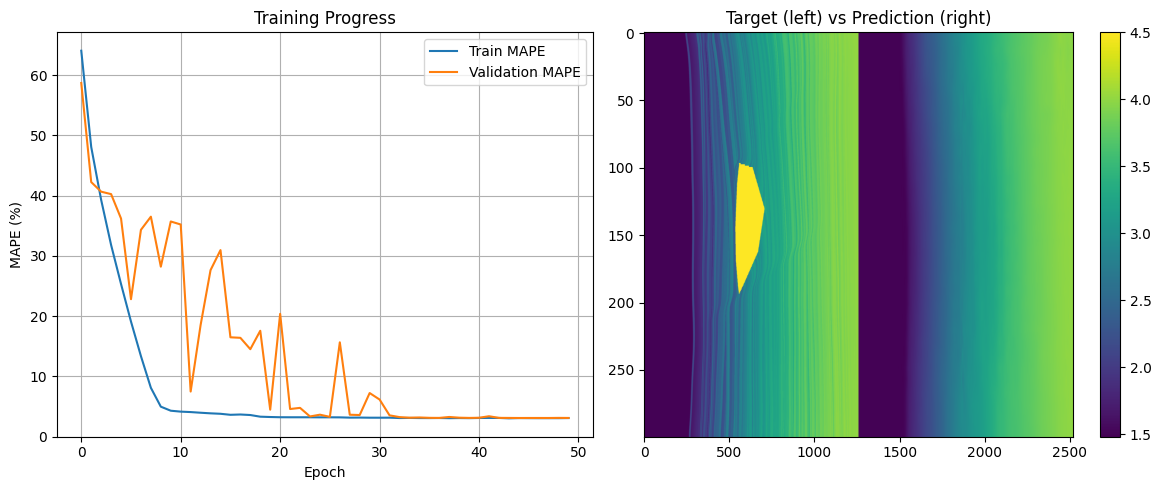


Training completed!
Best validation MAPE: 3.0773%
Model type: Adaptive


In [ ]:
# Main execution ADAPTIVE
if __name__ == "__main__":

    # Set data directory
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = Path('/content/drive/MyDrive/ThinkOnward/Data/Train')  # Adjust path as needed
    result_dir= Path('/content/drive/MyDrive/ThinkOnward/Result')

    # Create sample indices (assuming folders are named sample_0000, sample_0001, etc.)
    sample_indices = list(range(1,2001))  # Adjust based on your actual data

    # Train-validation split
    train_indices, val_indices = train_test_split(
        sample_indices,
        train_size=TRAIN_VAL_SPLIT,
        random_state=42
    )

    print(f"Training samples: {len(train_indices)}")
    print(f"Validation samples: {len(val_indices)}")

    # Create datasets
    train_dataset = SeismicDataset(data_dir, train_indices, use_adaptive=USE_ADAPTIVE_MODEL)
    val_dataset = SeismicDataset(data_dir, val_indices, use_adaptive=USE_ADAPTIVE_MODEL)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)

    # Initialize model
    model = UNet(in_channels=5, out_channels=1, use_adaptive=USE_ADAPTIVE_MODEL).to(DEVICE)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Test with one batch to verify shapes
    print("\nTesting model with one batch...")
    test_input, test_target = next(iter(train_loader))
    test_input = test_input.to(DEVICE)
    test_target = test_target.to(DEVICE)

    print(f"Input shape: {test_input.shape}")
    print(f"Target shape: {test_target.shape}")

    with torch.no_grad():
        test_output = model(test_input)
        print(f"Output shape: {test_output.shape}")
        print(f"Test MAPE: {mape_loss(test_output, test_target.unsqueeze(1)).item():.4f}%")

    print("\nStarting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, NUM_EPOCHS)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plot_name =f"plot_{'Adaptive' if USE_ADAPTIVE_MODEL else 'Resize'}"
    plot_dir = result_dir / plot_name

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train MAPE')
    plt.plot(val_losses, label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE (%)')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Show a sample prediction
    model.eval()
    with torch.no_grad():
        sample_input, sample_target = next(iter(val_loader))
        sample_input = sample_input.to(DEVICE)
        sample_pred = model(sample_input)

        sample_target_np = sample_target[0].cpu().numpy()
        sample_pred_np = sample_pred[0, 0].cpu().numpy()

        plt.subplot(1, 2, 2)
        plt.imshow(np.hstack([sample_target_np, sample_pred_np]), aspect='auto')
        plt.title('Target (left) vs Prediction (right)')
        plt.colorbar()

    plt.tight_layout()
    plt.savefig(plot_dir)
    plt.show()

    print(f"\nTraining completed!")
    print(f"Best validation MAPE: {min(val_losses):.4f}%")
    print(f"Model type: {'Adaptive' if USE_ADAPTIVE_MODEL else 'Resize'}")